<a href="https://colab.research.google.com/github/LuwamMKefali/IPCV_Project/blob/main/assignment_module_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 15.72 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.



---



# Experiment start

# Setup runtime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

CHECKPOINT_DIR = "/content/drive/MyDrive/ipcv_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Checkpoint directory:", CHECKPOINT_DIR)

Checkpoint directory: /content/drive/MyDrive/ipcv_checkpoints


# Imports

In [ ]:
!pip install -q torchmetrics


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from torchmetrics.classification.accuracy import Accuracy, MulticlassAccuracy
from tqdm import tqdm
import copy

def seed_everything(seed=42):
   # We fix all random seeds so that our experiments are reproducible
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

   # we make cudnn deterministic to avoid randomness in convolutions

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Data Handling and Transformations**


We are solving a multi-class image classification problem on the Oxford-IIIT Pet dataset. The images have different resolutions, lighting conditions, and object positions, so we need to standardize the inputs before feeding them into the model.


## Transforming the Dataset

1) **Resizing (160×160)**  
We resize all images to 160×160 to make training faster and more memory efficient. This resolution is a good compromise: small enough to reduce computation, but large enough to preserve breed-specific details.

2) **Data Augmentation (Training only)**  
We apply random resized cropping, horizontal flipping, and mild color jitter.  
This increases data variability and helps reduce overfitting, which is important since the dataset is relatively small. Without augmentation, validation accuracy dropped in earlier experiments.

(Transforms documentation: https://pytorch.org/vision/stable/transforms.html)

3) **Normalization**  
We normalize using ImageNet mean and standard deviation. This stabilizes training and prevents gradient issues, as discussed in LeCun et al., *Efficient BackProp* (1998):  
https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf  

For validation and testing, we remove randomness and only apply resizing and center cropping to ensure consistent and fair evaluation.




In [ ]:
IMG_SIZE = 160
BATCH_SIZE = 64
NUM_WORKERS = 0

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

eval_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

train_ds = OxfordPetDataset(split="train", transform=train_tf)
val_ds   = OxfordPetDataset(split="val", transform=eval_tf)
test_ds  = OxfordPetDataset(split="test", transform=eval_tf)

num_classes = train_ds.get_num_classes()
num_classes

37

We use PyTorch’s `DataLoader` to load the dataset in mini-batches.

- The **training loader** uses `shuffle=True` so the model sees the data in a different order every epoch, which helps generalization.
- The **validation and test loaders** use `shuffle=False` to keep evaluation consistent and reproducible.

`pin_memory=True` speeds up GPU data transfer, and `num_workers=0` ensures stable execution across environments.

Finally, checking the length of each loader confirms how many batches exist in each split.

Documentation: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [ ]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

(58, 29, 29)

## Label to names

We will map the label to their corresponding breed names.

In [ ]:
def get_class_names(dataset):

    names = dataset.names

    class_names = []

    for name in names:
        breed = "_".join(name.split("_")[:-1])
        class_names.append(breed)

    unique_classes = sorted(list(set(class_names)))

    return unique_classes

In [ ]:
# We extract class names from training dataset
class_names = get_class_names(train_ds)

print("Number of classes:", len(class_names))
print("First 5 classes:", class_names[:5])

Number of classes: 37
First 5 classes: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']



During preprocessing, we normalized images using ImageNet mean and standard deviation.  
Before visualizing them, we need to reverse that operation.

This function multiplies by the standard deviation and adds back the mean to restore the original pixel distribution. We also clamp values between 0 and 1 to ensure valid image intensities.

This step is only used for visualization purposes.  
The model itself always works with normalized inputs.

In [ ]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (img_tensor.cpu() * std + mean).clamp(0,1)

In [ ]:
def show_training_samples(dataset, class_names, num_samples=5):

    shown_classes = set()
    selected_images = []

    # we want to collect samples from different classes
    for img, label in dataset:
        if label not in shown_classes:
            selected_images.append((img, label))
            shown_classes.add(label)

        if len(selected_images) == num_samples:
            break

    plt.figure(figsize=(14,4))

    for i, (img, label) in enumerate(selected_images):

        # Undo normalization
        img = denormalize(img).permute(1,2,0).numpy()
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")

    plt.suptitle("Training Samples")
    plt.tight_layout()
    plt.show()



---



# **Plotting Functions**

## Visualization of Training Curves

For each experiment, Iwe visualize:

- Training vs Validation Loss
- Training vs Validation Accuracy
- Learning rate

This allows us to detect:
- Overfitting
- Underfitting
- Convergence stability

In [ ]:
def plot_summary(history, title="Training Summary"):

    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    # loss
    axes[0].plot(epochs, history["train_loss"], label="Train", linewidth=2)
    axes[0].plot(epochs, history["val_loss"], label="Val", linestyle="--", linewidth=2)
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].legend()
    axes[0].grid(True)

    # accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train", linewidth=2)
    axes[1].plot(epochs, history["val_acc"], label="Val", linestyle="--", linewidth=2)
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].legend()
    axes[1].grid(True)

    # learning rate
    axes[2].plot(epochs, history["lr"], linewidth=2)
    axes[2].set_title("Learning Rate")
    axes[2].set_xlabel("Epochs")
    axes[2].grid(True)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_learning_rate(history):

    if "lr" not in history:
        print("Learning rate not tracked in history.")
        return

    epochs = range(1, len(history["lr"]) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["lr"], linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.show()



---



# **Checkpoint Utilities**

We have learnt the hard way the importance of saving the checkpoint and loading our saved models. Since most runs are long and we have been susceptile to disconnections.  It is also best practice..

In [ ]:
import os
import torch

def save_checkpoint(model_name, epoch, model, optimizer, scheduler,
                    best_val_acc, history):

    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.pt")

    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict() if optimizer else None,
        "scheduler_state": scheduler.state_dict() if scheduler else None,
        "best_val_acc": best_val_acc,
        "history": history
    }

    torch.save(checkpoint, checkpoint_path)

    print(f"Checkpoint saved to {checkpoint_path}")


def load_checkpoint(model_name, model, optimizer=None, scheduler=None):

    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.pt")

    if not os.path.exists(checkpoint_path):
        print("No checkpoint found.")
        return 1, 0.0, {
            "train_loss": [], "train_acc": [],
            "val_loss": [], "val_acc": [],
            "lr": []
        }

    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])

    if optimizer and checkpoint["optimizer_state"]:
        optimizer.load_state_dict(checkpoint["optimizer_state"])

    if scheduler and checkpoint["scheduler_state"]:
        scheduler.load_state_dict(checkpoint["scheduler_state"])

    print(f"Resuming {model_name} from epoch {checkpoint['epoch']}")

    return checkpoint["epoch"] + 1, \
           checkpoint["best_val_acc"], \
           checkpoint["history"]

# **Model Analysis Utilities**

This utilities are defined because we will want to visualiza how our best model performed per class and see class wise visualizations on a selected samples.

In [ ]:
def final_model_analysis(model_class,
                         model_name,
                         num_classes,
                         base_ch,
                         dropout_p,
                         test_loader,
                         device,
                         num_samples=10):

    print(f"Analyzing Model: {model_name}")

    # Load Model
    model = model_class(
        num_classes=num_classes,
        base_ch=base_ch,
        dropout_p=dropout_p
    ).to(device)

    checkpoint = torch.load(
        f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt",
        map_location=device
    )

    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    # Compute Test Accuracy
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Collect Predictions
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Get Class Names
    class_names = get_class_names(test_loader.dataset)

    # Compute Per-Class Accuracy
    import numpy as np

    num_classes = len(class_names)
    per_class_correct = np.zeros(num_classes)
    per_class_total = np.zeros(num_classes)

    for true, pred in zip(all_labels, all_preds):
        per_class_total[true] += 1
        if true == pred:
            per_class_correct[true] += 1

    per_class_acc = per_class_correct / per_class_total

    # Plot Per-Class Accuracy
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))
    plt.bar(range(num_classes), per_class_acc * 100, color="green")
    plt.xticks(range(num_classes), class_names, rotation=90, fontsize=6)
    plt.ylabel("Accuracy (%)")
    plt.title("Per-Class Accuracy")
    plt.tight_layout()
    plt.show()

    # Show Sample Predictions

    import random

    indices = random.sample(range(len(test_loader.dataset)), num_samples)

    plt.figure(figsize=(12, 5))

    for i, idx in enumerate(indices):
        image, label = test_loader.dataset[idx]

        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()

        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-5)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"T: {class_names[label]}\nP: {class_names[pred]}", fontsize=7)

    plt.tight_layout()
    plt.show()



---



##  **Dataset Inspection and Distribution Analysis**

Before training, we visualize the number of samples per class in the train, validation, and test splits.

The function:
- Extracts labels from each dataset.
- Counts how many samples belong to each class using `np.bincount`.
- Plots a grouped bar chart to compare class frequencies across splits.

This helps us inspect whether:
- The dataset is reasonably balanced.
- class imbalance that could bias training.
- Splits consistency



In [ ]:
def plot_class_distribution(train_ds, val_ds, test_ds):

    # Extract labels
    train_labels = train_ds.labels
    val_labels   = val_ds.labels
    test_labels  = test_ds.labels

    # Determine no of classes
    num_classes = max(train_labels + val_labels + test_labels) + 1

    # Count occurrences per class
    train_counts = np.bincount(train_labels, minlength=num_classes)
    val_counts   = np.bincount(val_labels, minlength=num_classes)
    test_counts  = np.bincount(test_labels, minlength=num_classes)

    classes = np.arange(num_classes)
    width = 0.25
    plt.figure(figsize=(16,6))

    plt.bar(classes - width, train_counts, width=width, label="train")
    plt.bar(classes,         val_counts,   width=width, label="val")
    plt.bar(classes + width, test_counts,  width=width, label="test")

    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution Across Datasets")
    plt.xticks(classes)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

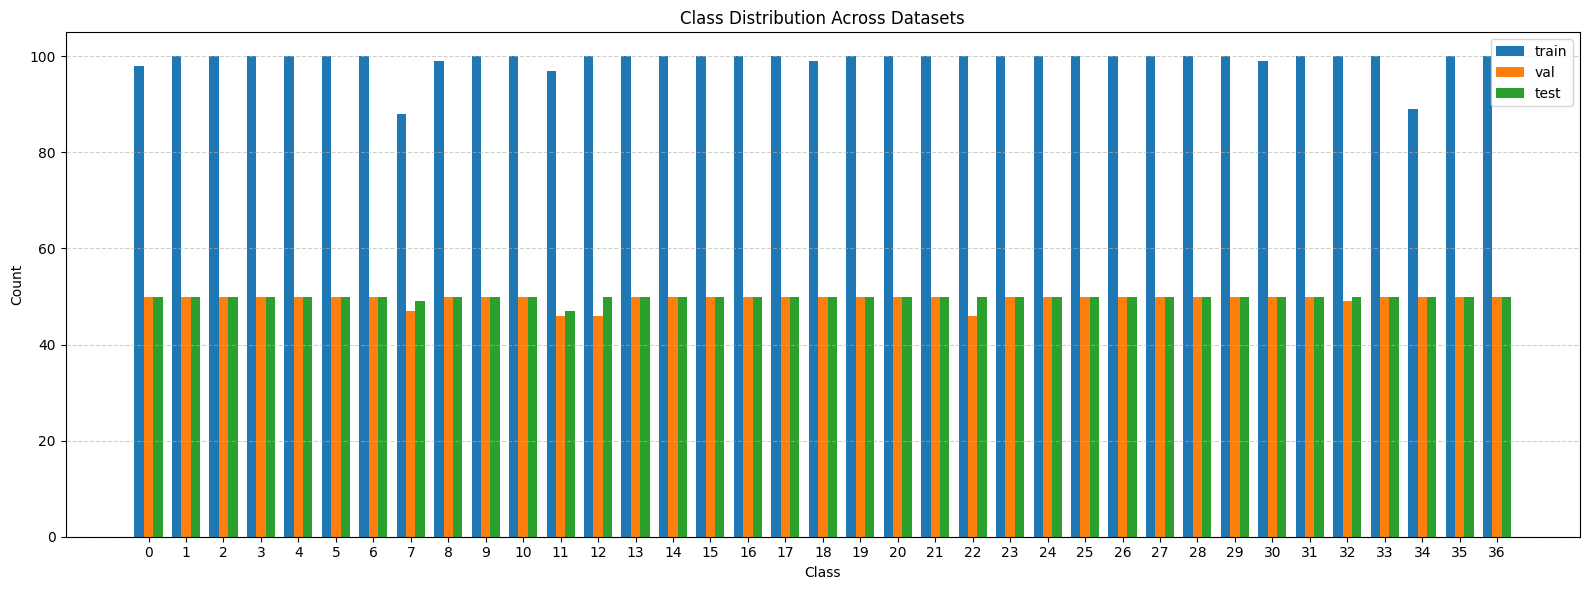

In [ ]:
plot_class_distribution(train_ds, val_ds, test_ds)

### 📊 Class Distribution Analysis

The dataset appears to be nearly uniformly distributed across all 37 classes in the train, validation, and test splits.  
Each class contains roughly the same number of samples, with only small variations in a few categories.  
This indicates that the dataset is well balanced, which reduces the risk of biased learning toward dominant classes.  

If we observed strong imbalance, we would need strategies like weighted loss or resampling. In our case, the distribution is fairly uniform, so standard cross-entropy training is justified.

As a result, performance differences observed during training and ablation studies can be attributed more confidently to architectural or regularization changes rather than class imbalance.

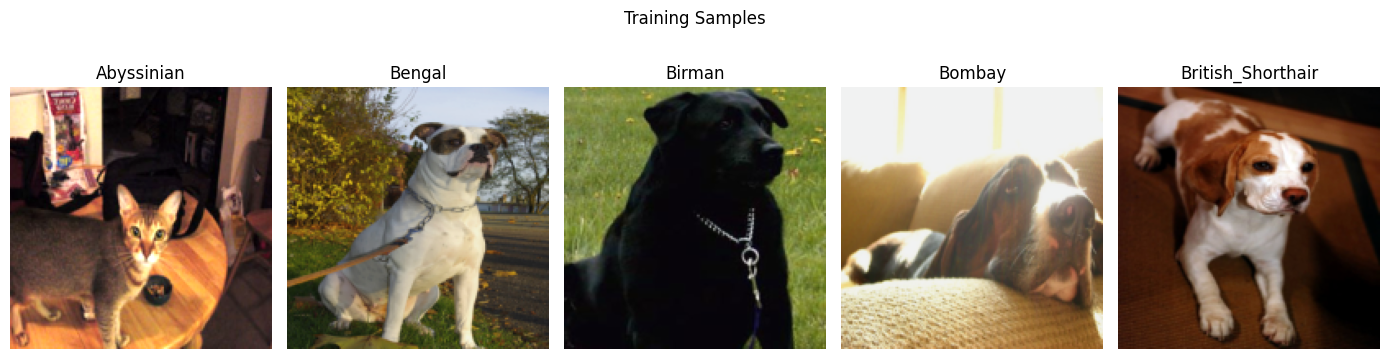

In [ ]:
show_training_samples(train_ds, class_names, num_samples=5)



---



# **Training utilities**

In [ ]:
import pandas as pd
hyperparam_summary = {}
architecture_summary = {}

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 🔀 Mixup Data Augmentation

Mixup is a data augmentation technique where two training images and their corresponding labels are linearly combined to create a new synthetic training example [(Zhang et al., 2018)](https://arxiv.org/abs/1710.09412).  
Instead of training on hard one-hot labels, the model learns from soft interpolated targets, which encourages smoother decision boundaries.  
This acts as a form of regularization and can improve generalization, especially when the dataset is limited in size.  

In our experiment, Mixup is applied during training to reduce overfitting and improve validation performance, in addition to the transformations we applied earlier.

In [ ]:
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

In [ ]:
from dataclasses import dataclass

@dataclass
class EpochStats:
    loss: float
    acc: float

def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()


def train_one_epoch(model, loader, optimizer, criterion,
                    use_mixup=False, mixup_alpha=0.4):

    model.train()

    total_loss = 0
    total_acc = 0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)

        # -Mixup
        if use_mixup:
            x, y_a, y_b, lam = mixup_data(x, y, alpha=mixup_alpha)
            logits = model(x)
            loss = lam * criterion(logits, y_a) + \
                   (1 - lam) * criterion(logits, y_b)

            # approximate accuracy
            acc = accuracy_from_logits(logits, y_a)

        else:
            logits = model(x)
            loss = criterion(logits, y)
            acc = accuracy_from_logits(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()

    total_loss = 0
    total_acc = 0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

In [ ]:
def fit(model,
        model_name,
        train_loader,
        val_loader,
        epochs=150,
        lr=1e-3,
        weight_decay=1e-2,
        use_mixup=True,
        mixup_alpha=0.4,
        resume=False,
        scheduler_type="cosine"):

    # Standard cross-entropy for multiclass classification
    criterion = nn.CrossEntropyLoss()

    # AdamW is chosen instead of Adam because it decouples weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    # We experiment with different LR schedules to study their impact

    if scheduler_type == "cosine":
        # Cosine annealing smoothly decreases LR over epochs
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs
        )

    elif scheduler_type == "step":

        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=30,   # reduce every 30 epochs
            gamma=0.1       # multiply LR by 0.1
        )

    elif scheduler_type == "none":

        scheduler = None

    else:
        raise ValueError("Invalid scheduler_type. Choose 'cosine', 'step', or 'none'.")

    # resume training from checkpoint
    if resume:
        start_epoch, best_val_acc, history = load_checkpoint(
            model_name, model, optimizer, scheduler
        )
    else:
        start_epoch = 1
        best_val_acc = 0.0

        # We track losses, accuracies and LR to analyze training later
        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "lr": []
        }

    # Early stopping setup
    patience = 10  # stop if no val improvement for 10 epochs
    epochs_no_improve = 0

    for epoch in range(start_epoch, epochs + 1):

        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            use_mixup=use_mixup,        # optional mixup regularization
            mixup_alpha=mixup_alpha
        )

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # Store metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Track current lr
        current_lr = optimizer.param_groups[0]["lr"]
        history["lr"].append(current_lr)

        # Check if this is the best validation accuracy so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0  # reset counter if improvement

            # Save best model checkpoint
            save_checkpoint(
                model_name,
                epoch,
                model,
                optimizer,
                scheduler,
                best_val_acc,
                history
            )

            print(f"New best model saved ({model_name}) "
                  f"epoch {epoch}, val acc {val_acc*100:.2f}%")

        else:
            epochs_no_improve += 1  # count epochs without improvement

        print(f"Epoch {epoch} | "
              f"Train Loss {train_loss:.4f} | "
              f"Train Acc {train_acc*100:.2f}% | "
              f"Val Loss {val_loss:.4f} | "
              f"Val Acc {val_acc*100:.2f}%")

        # Update learning rate if scheduler is enabled
        if scheduler is not None:
            scheduler.step()

        # early stopping condition
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    return history, best_val_acc



---



## **Architecture and Experiments**

## Model Architecture - ResNet-Inspired CNN

Our final selected model is a lightweight ResNet-style CNN (~2.8M parameters).  
We chose it because it achieved ~70% test accuracy (above the 60% requirement) while keeping the parameter count reasonable for a ~7k image dataset. The remaining experiments are ablations of this base model.


## ResidualBlock

The block is inspired by ResNet (He et al., 2016 – https://arxiv.org/abs/1512.03385).

Instead of learning a direct mapping, the block learns a residual function:

\[
F(x) + x
\]

This improves gradient flow and stabilizes training compared to a plain CNN.

Each block contains:
- Two 3×3 convolutions
- Batch Normalization
- ReLU
- Optional Dropout
- A skip connection (identity or 1×1 conv if dimensions change)

If stride or channels change, a 1×1 convolution aligns dimensions before addition.



## PetResNet_v1 Design

### Stem  
A small 3×3 convolution initializes feature extraction without aggressively reducing resolution. This preserves spatial details important for breed classification.

### Stages  
The network is divided into 4 stages.  
At the start of each new stage (except the first), spatial resolution is reduced (stride=2), while the number of channels doubles.

This follows a standard CNN pattern:
- Decrease spatial size gradually.
- Increase feature depth to learn more abstract representations.

### Dropout  
Dropout is introduced in deeper stages. Earlier layers learn general features (edges, textures), while deeper layers are more prone to overfitting.

### Global Average Pooling  
We use adaptive average pooling instead of large fully connected layers. This:
- Reduces parameters,
- Improves generalization,
- Keeps the model lightweight.





In [ ]:
class ResidualBlock(nn.Module):
    '''
     A ResNet inspired model
    '''
    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

        # Skip path, identity if same shape, otherwise 1x1 conv to match dims
        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.dropout(out)

        out = out + identity
        out = F.relu(out, inplace=True)
        return out


class PetResNet_v1(nn.Module):
    def __init__(self, num_classes, base_ch=32, dropout_p=0.10):
        super().__init__()

        # Stem- small conv to get started without killing resolution too fast
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        # Stagesdownsample by stride=2 at the start of each stage (except first)
        self.stage1 = nn.Sequential(
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
        )

        self.stage2 = nn.Sequential(
            ResidualBlock(base_ch, base_ch*2, stride=2, dropout_p=0.0),
            ResidualBlock(base_ch*2, base_ch*2, stride=1, dropout_p=0.0),
        )

        self.stage3 = nn.Sequential(
            ResidualBlock(base_ch*2, base_ch*4, stride=2, dropout_p=0.05),
            ResidualBlock(base_ch*4, base_ch*4, stride=1, dropout_p=0.05),
        )

        self.stage4 = nn.Sequential(
            ResidualBlock(base_ch*4, base_ch*8, stride=2, dropout_p=0.10),
            ResidualBlock(base_ch*8, base_ch*8, stride=1, dropout_p=0.10),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch*8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x).flatten(1)
        x = self.head(x)
        return x

In [ ]:
model = PetResNet_v1(num_classes=num_classes, base_ch=32, dropout_p=0.20).to(device)
sum(p.numel() for p in model.parameters()) / 1e6

2.804549

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 1, val acc 5.17%
Epoch 1 | Train Loss 3.6195 | Train Acc 5.17% | Val Loss 3.8139 | Val Acc 5.17%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 2, val acc 6.98%
Epoch 2 | Train Loss 3.4907 | Train Acc 7.09% | Val Loss 3.4862 | Val Acc 6.98%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 3, val acc 7.54%
Epoch 3 | Train Loss 3.4401 | Train Acc 7.70% | Val Loss 3.5640 | Val Acc 7.54%
Epoch 4 | Train Loss 3.3765 | Train Acc 9.33% | Val Loss 3.4526 | Val Acc 6.95%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 5, val acc 9.76%
Epoch 5 | Train Loss 3.3682 | Train Acc 8.73% | Val Loss 3.3640 | Val Acc 9.76%
Epoch 6 | Train Loss 3.3000 | Train Acc 10.35% | Val Loss 3.

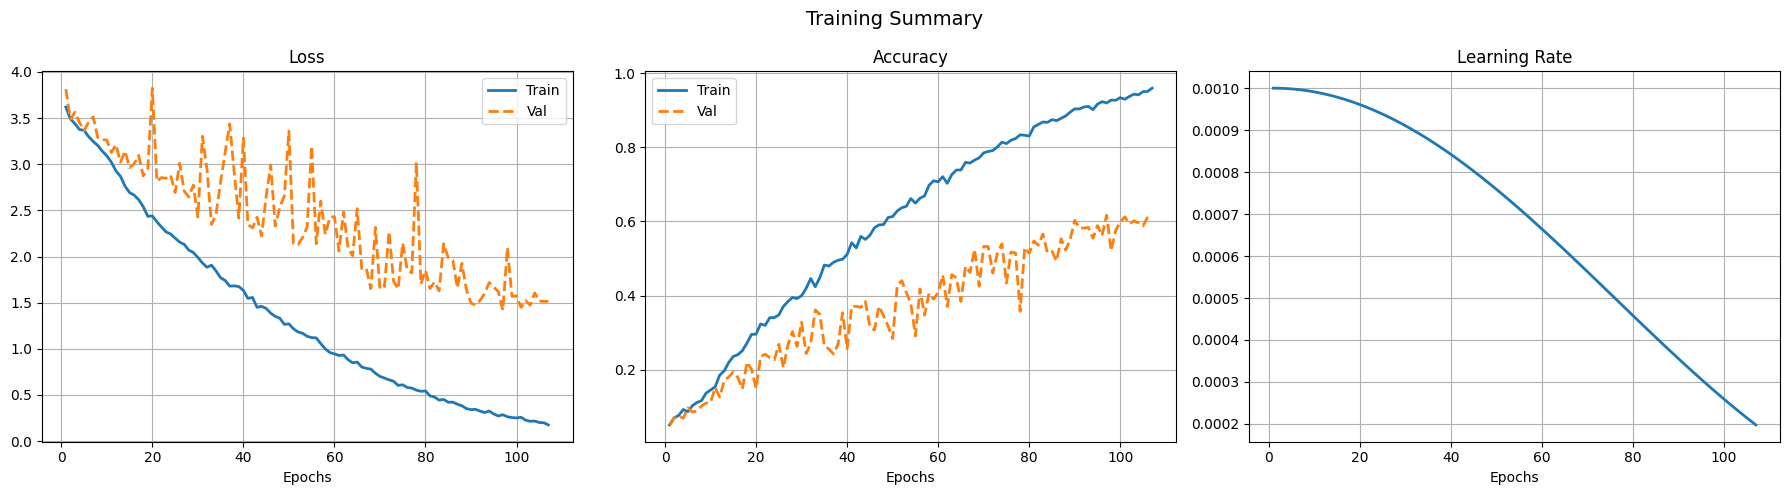

In [ ]:
model_name = "PetResNet_v1"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history, best_val = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=False,
    mixup_alpha=0.4,
    resume=False

)
print(f"\nBest Validation Accuracy: {best_val*100:.2f}%")
plot_summary(history)

### Testing

In [ ]:
model_name = "PetResNet_v1"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints//{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_nomix, test_acc_nomix = evaluate(model, test_loader, criterion)

print(f"No-Mixup model Test Accuracy: {test_acc_nomix * 100:.2f}%")
print(f"Test Loss: {test_loss_nomix:.4f}")

No-Mixup model Test Accuracy: 65.08%
Test Loss: 1.2757


## Observations

- Residual connections improved training stability.
- Gradual downsampling preserved useful spatial information.
- Adding moderate dropout improved validation accuracy.
- Making the network deeper increased overfitting without improving test accuracy.

To mitigate the overfitting issue, we will retrain the same model but with [Mixup](https://arxiv.org/abs/1710.09412) enabled.

#### Save results

In [ ]:
# No Mixup
checkpoint_nomix = torch.load(
    "/content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt",
    map_location=device
)

best_val_nomix = checkpoint_nomix["best_val_acc"]
history_nomix = checkpoint_nomix["history"]

hyperparam_summary["PetResNet_v1_nomix"] = {
    "mixup": False,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealing",
    "Validation_accuracy (%)": round(best_val_nomix * 100, 2),
    "test_accuracy (%)": round(test_acc_nomix * 100, 2),
    "epochs_trained": len(history_nomix["train_loss"])
}

# **Baseline model with Mixup enabled**

In [ ]:
model = PetResNet_v1(num_classes=num_classes, base_ch=32, dropout_p=0.20).to(device)
params_mixup = count_parameters(model)
params_mixup_m = round(params_mixup / 1e6, 3)

In [ ]:
model_name = "PetResNet_v1_mixup"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history, best_val = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False

)
print(f"\nBest Validation Accuracy: {best_val*100:.2f}%")
plot_summary(history, title="PetResNet_v1 (Mixup)")

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 1, val acc 4.65%
Epoch 1 | Train Loss 3.6535 | Train Acc 2.91% | Val Loss 6.3368 | Val Acc 4.65%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 2, val acc 5.23%
Epoch 2 | Train Loss 3.5631 | Train Acc 4.72% | Val Loss 3.5700 | Val Acc 5.23%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 3, val acc 6.88%
Epoch 3 | Train Loss 3.5160 | Train Acc 4.61% | Val Loss 3.5093 | Val Acc 6.88%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 4, val acc 7.22%
Epoch 4 | Train Loss 3.4793 | Train Acc 4.74% | Val Loss 3.4963 | Val Acc 7.22%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best m

Runtime disconnected

Resuming PetResNet_v1_mixup from epoch 66
Epoch 67 | Train Loss 1.6803 | Train Acc 36.36% | Val Loss 1.8883 | Val Acc 46.73%
Epoch 68 | Train Loss 1.6563 | Train Acc 38.80% | Val Loss 2.0255 | Val Acc 43.80%
Epoch 69 | Train Loss 1.6392 | Train Acc 35.97% | Val Loss 1.7365 | Val Acc 50.96%
Epoch 70 | Train Loss 1.5739 | Train Acc 35.19% | Val Loss 1.7969 | Val Acc 49.03%
Epoch 71 | Train Loss 1.7345 | Train Acc 29.71% | Val Loss 1.7612 | Val Acc 49.19%
Epoch 72 | Train Loss 1.6957 | Train Acc 27.41% | Val Loss 1.6946 | Val Acc 52.60%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 73, val acc 54.82%
Epoch 73 | Train Loss 1.5221 | Train Acc 33.03% | Val Loss 1.5846 | Val Acc 54.82%
Epoch 74 | Train Loss 1.5881 | Train Acc 40.72% | Val Loss 1.7290 | Val Acc 51.01%
Epoch 75 | Train Loss 1.5499 | Train Acc 43.04% | Val Loss 1.9970 | Val Acc 45.04%
Epoch 76 | Train Loss 1.6687 | Train Acc 32.76% | Val Loss 1.7

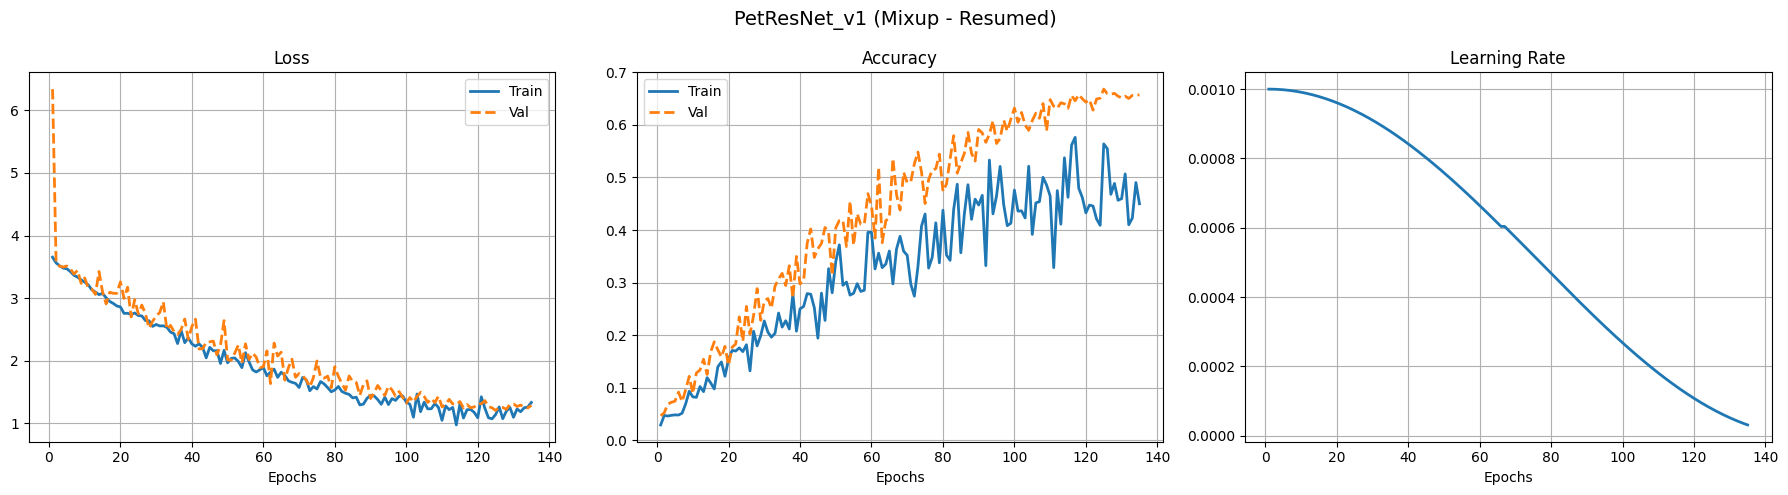

In [ ]:
# we will resume training from the last saved checkpoint
model_name = "PetResNet_v1_mixup"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Resume training
history, best_val = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=True
)

print(f"\nBest Validation Accuracy: {best_val*100:.2f}%")
plot_summary(history, title="PetResNet_v1 (Mixup)")

### PetResNet_v1_mixup test

In [ ]:
model_name = "PetResNet_v1_mixup"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Load best saved weights
checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"Mixup model Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Mixup model Test Loss: 1.1250
Test Accuracy: 69.58%


### Effect of Mixup on Training

Without regularization, the model quickly reaches very high training accuracy, indicating potential overfitting.  
Mixup helped counter this by softening labels and preventing the network from memorizing individual samples.  
This led to slightly slower convergence but improved validation stability.  

Comparing the baseline model with and without Mixup, we got a 4% incease in test accuracy whilst basically removing the overfitting issue. Thus the Mixup enabled modl is the best model we are going to work with.

#### Save results

In [ ]:
# with mixup
checkpoint_mix = torch.load(
    "/content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt",
    map_location=device
)

best_val_mix = checkpoint_mix["best_val_acc"]
history_mix = checkpoint_mix["history"]

hyperparam_summary["PetResNet_v1_mixup"] = {
    "mixup": True,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealing",
    "Validation_accuracy (%)": round(best_val_mix * 100, 2),
    "test_accuracy (%)": round(test_acc* 100, 2),
    "epochs_trained": len(history_mix["train_loss"])
}

architecture_summary["PetResNet_v1_mixup"] = {
    "residual_connections": True,
    "batch_norm": True,
    "blocks_per_stage": 2,
    "num_stages": 4,
    "base_channels": 32,
    "Parameters (M)": params_mixup_m,
    "Validation_accuracy (%)": round(best_val_mix * 100, 2),
    "test_accuracy (%)": round(test_acc * 100, 2),
    "epochs_trained": len(history_mix["train_loss"])
}



---



# **Ablation studies**

## Ablation Study Structure

| **A. Hyperparameter Ablation** | **B. Architectural Ablation** |
|--------------------------------|--------------------------------|
| We analyze the impact of training-related choices such as regularization and optimization. | We analyze the impact of model structure and representational capacity. |
| Includes: dropout, weight decay, scheduler, mixup. | Includes: depth, residual connections, BatchNorm, number of stages. |

# **A. Hyperparameter Ablation**


## Ablation A1 - **Zero Dropout**

In this experiment, dropout is removed while keeping Mixup enabled during training.  
Since Mixup already acts as a strong regularization technique by creating interpolated training samples, the model may not require additional stochastic regularization from dropout.  
This ablation evaluates whether dropout provides complementary benefits beyond Mixup or becomes redundant when Mixup is applied.  
If validation performance remains stable, it would suggest that Mixup alone is sufficient for regularization.

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v2_no_dropout.pt
New best model saved (PetResNet_v2_no_dropout) epoch 1, val acc 4.15%
Epoch 1 | Train Loss 3.6272 | Train Acc 3.10% | Val Loss 3.6792 | Val Acc 4.15%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v2_no_dropout.pt
New best model saved (PetResNet_v2_no_dropout) epoch 2, val acc 5.93%
Epoch 2 | Train Loss 3.5192 | Train Acc 5.09% | Val Loss 3.7156 | Val Acc 5.93%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v2_no_dropout.pt
New best model saved (PetResNet_v2_no_dropout) epoch 3, val acc 7.27%
Epoch 3 | Train Loss 3.4879 | Train Acc 4.82% | Val Loss 3.4069 | Val Acc 7.27%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v2_no_dropout.pt
New best model saved (PetResNet_v2_no_dropout) epoch 4, val acc 8.89%
Epoch 4 | Train Loss 3.4151 | Train Acc 6.38% | Val Loss 3.3984 | Val Acc 8.89%
Epoch 5 | Train Loss 3.3597 | Train Acc 7.93% | Val 

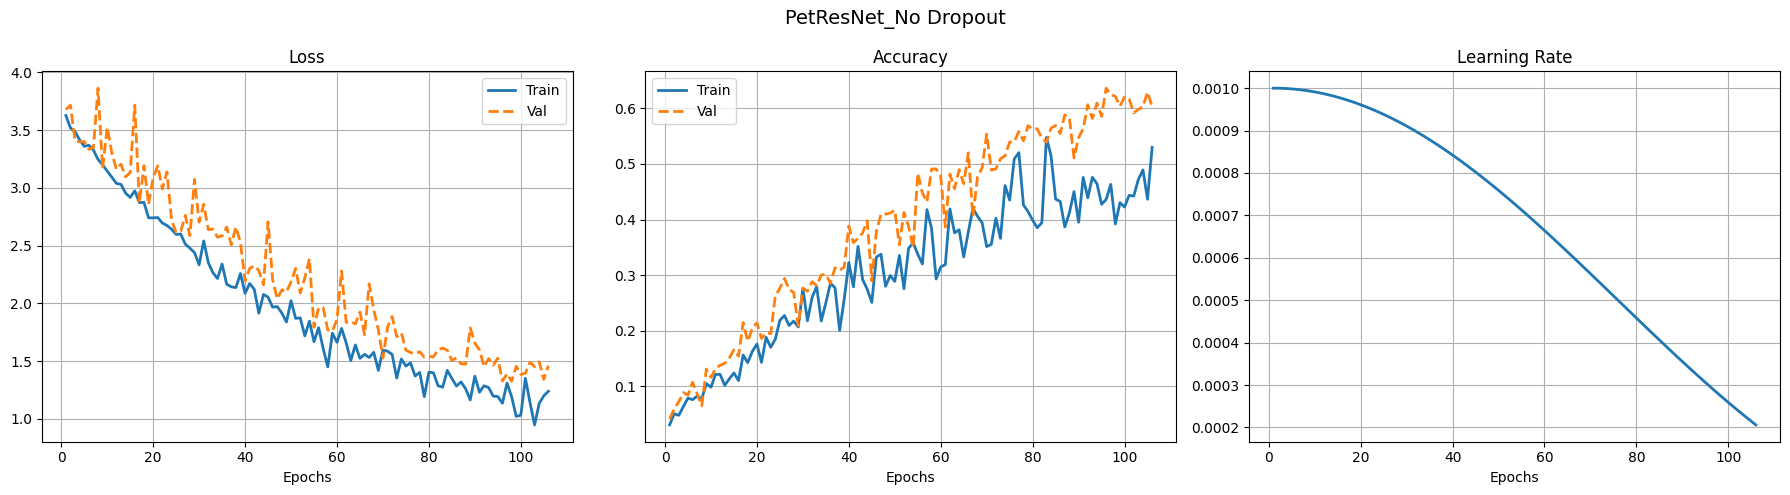

In [ ]:
model_name = "PetResNet_v2_no_dropout"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.0
).to(device)

history_v2, best_val_v2 = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\n(No Dropout) Best Validation Accuracy: {best_val_v2*100:.2f}%")

plot_summary(
    history_v2,
    title="PetResNet_No Dropout"
)

In [ ]:
model_name = "PetResNet_v2_no_dropout"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.0
).to(device)

# Load best saved weights
checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_v2, test_acc_v2 = evaluate(model, test_loader, criterion)

print(f"Test Loss (No dropout): {test_loss_v2:.4f}")
print(f"Test Accuracy (No dropout): {test_acc_v2 * 100:.2f}%")

Test Loss (No dropout): 1.2651
Test Accuracy (No dropout): 64.07%


### Observation (**Dropout**)

|  | **Best Model** | **No Dropout** |
|---|---------------|---------------|
| **Test Loss** | 1.1250 | 1.2651 |
| **Test Accuracy (%)** | 69.58 | 64.07 |

Removing dropout causes a clear degradation in performance (~5.5% drop in accuracy and higher test loss).

This indicates that dropout is effectively acting as regularization. Without it, the model likely overfits the training data, leading to weaker generalization on the test set.

The higher loss also suggests less confident or less well-calibrated predictions.

Conclusion: dropout meaningfully improves generalization for this architecture and dataset size.

In [ ]:
# with dropout removed
hyperparam_summary["PetResNet_v2_no_dropout"] = {
    "mixup": True,
    "base_channels": 32,
    "dropout": 0.0,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealing",
    "Validation_accuracy (%)": round(best_val_v2 * 100, 2),
    "test_accuracy (%)": round(test_acc_v2* 100, 2),
    "epochs_trained": len(history_v2["train_loss"])
}

## Ablation A2 - **No Weight Decay**

In this experiment, we set weight decay to zero while keeping the optimizer, learning rate, Mixup, and architecture unchanged.  
Weight decay acts as an L2 regularization term that penalizes large weights and encourages smoother solutions.  
By removing weight decay, we evaluate whether explicit parameter regularization contributes to generalization performance in this setup.  
Any decrease in validation accuracy would suggest that weight decay plays a meaningful role in stabilizing training.

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v3_no_weight_decay.pt
New best model saved (PetResNet_v3_no_weight_decay) epoch 1, val acc 4.31%
Epoch 1 | Train Loss 3.6402 | Train Acc 2.94% | Val Loss 3.5472 | Val Acc 4.31%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v3_no_weight_decay.pt
New best model saved (PetResNet_v3_no_weight_decay) epoch 2, val acc 4.57%
Epoch 2 | Train Loss 3.5480 | Train Acc 3.83% | Val Loss 3.8801 | Val Acc 4.57%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v3_no_weight_decay.pt
New best model saved (PetResNet_v3_no_weight_decay) epoch 3, val acc 5.87%
Epoch 3 | Train Loss 3.5054 | Train Acc 5.04% | Val Loss 3.4977 | Val Acc 5.87%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v3_no_weight_decay.pt
New best model saved (PetResNet_v3_no_weight_decay) epoch 4, val acc 6.73%
Epoch 4 | Train Loss 3.4603 | Train Acc 5.10% | Val Loss 3.6117 | Val Acc 6.73%
Checkpoint s

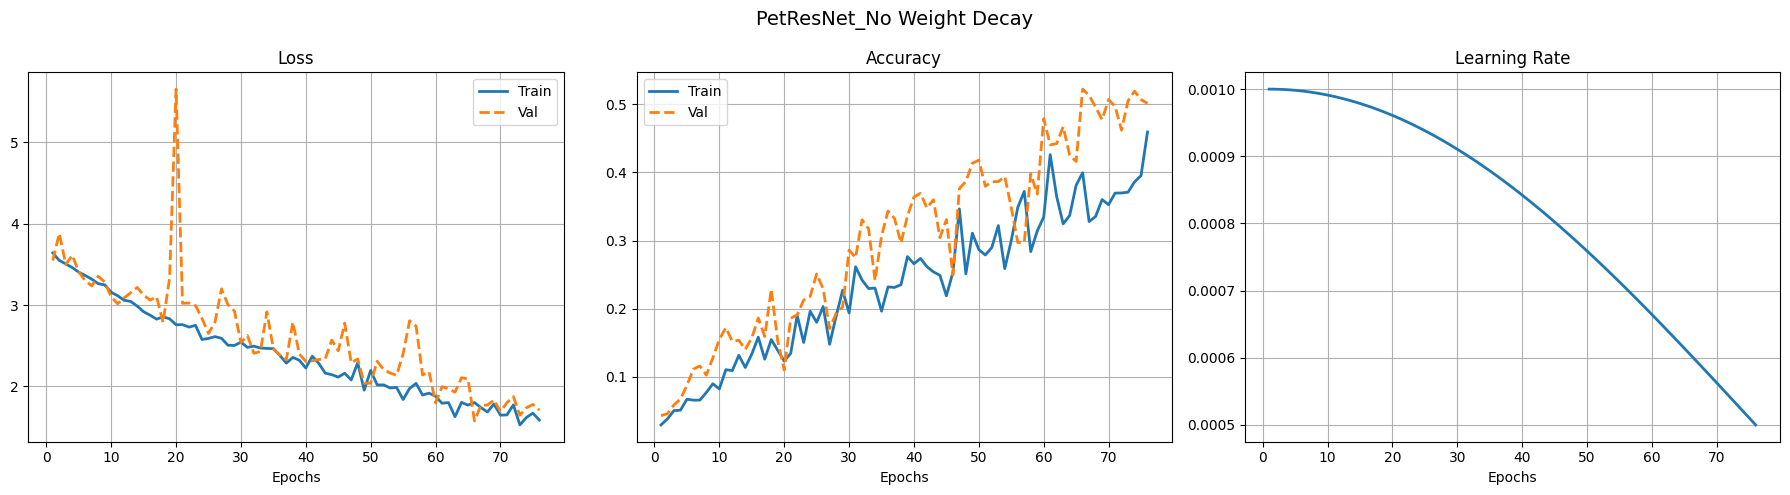

In [ ]:
model_name = "PetResNet_v3_no_weight_decay"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_v3, best_val_v3 = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=0.0,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\n(No Weight Decay) Best Validation Accuracy: {best_val_v3*100:.2f}%")

plot_summary(
    history_v3,
    title="PetResNet_No Weight Decay"
)

In [ ]:
model_name = "PetResNet_v3_no_weight_decay"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Load best saved weights
checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_v3, test_acc_v3 = evaluate(model, test_loader, criterion)

print(f"Test Loss (No weight decay): {test_loss_v3:.4f}")
print(f"Test Accuracy (No weight decay): {test_acc_v3 * 100:.2f}%")

Test Loss (No weight decay): 1.5105
Test Accuracy (No weight decay): 57.64%


### Observation (**Weight decay**)

|  | **Best Model** | **No Weight Decay** |
|---|---------------|---------------------|
| **Test Loss** | 1.1250 | 1.5105 |
| **Test Accuracy (%)** | 69.58 | 57.64 |

Removing weight decay leads to a dramatic performance drop (~12% accuracy decrease) and a much higher test loss.

This strongly suggests that weight decay ([L2 regularization](https://www.deeplearningbook.org/contents/regularization.html (Chapter 7, Goodfellow et al., *Deep Learning*)
)) is critical for controlling model complexity. Without it, the network likely learns overly large weights, fitting the training data too closely and generalizing poorly.

Compared to dropout, weight decay appears even more important in stabilizing this model.

Conclusion: weight decay is a key regularization component in our setup and should not be removed.

In [ ]:
# NO weight decay
hyperparam_summary["PetResNet_v3_no_weight_decay"] = {
    "mixup": True,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 0.0,
    "scheduler": "CosineAnnealing",
    "Validation_accuracy (%)": round(best_val_v3 * 100, 2),
    "test_accuracy (%)": round(test_acc_v3* 100, 2),
    "epochs_trained": len(history_v3["train_loss"])
}

## Ablation A3 - **Scheduler(StepLR)**

 To analyze the impact of learning rate scheduling, the cosine annealing scheduler is replaced with a StepLR scheduler while keeping all other hyperparameters fixed.  
StepLR decreases the learning rate by a fixed factor every predefined number of epochs, creating distinct training phases.  
This allows us to evaluate whether sharp learning rate reductions lead to better validation performance compared to smooth cosine decay.

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_stepLR.pt
New best model saved (PetResNet_stepLR) epoch 1, val acc 4.80%
Epoch 1 | Train Loss 3.6488 | Train Acc 3.48% | Val Loss 4.1803 | Val Acc 4.80%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_stepLR.pt
New best model saved (PetResNet_stepLR) epoch 2, val acc 7.11%
Epoch 2 | Train Loss 3.5533 | Train Acc 4.37% | Val Loss 3.5598 | Val Acc 7.11%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_stepLR.pt
New best model saved (PetResNet_stepLR) epoch 3, val acc 7.84%
Epoch 3 | Train Loss 3.5116 | Train Acc 4.61% | Val Loss 3.5588 | Val Acc 7.84%
Epoch 4 | Train Loss 3.4747 | Train Acc 6.28% | Val Loss 3.9753 | Val Acc 5.04%
Epoch 5 | Train Loss 3.4067 | Train Acc 6.23% | Val Loss 3.9085 | Val Acc 7.04%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_stepLR.pt
New best model saved (PetResNet_stepLR) epoch 6, val acc 10.00%
Epoch 6 | Train Loss 3.4134

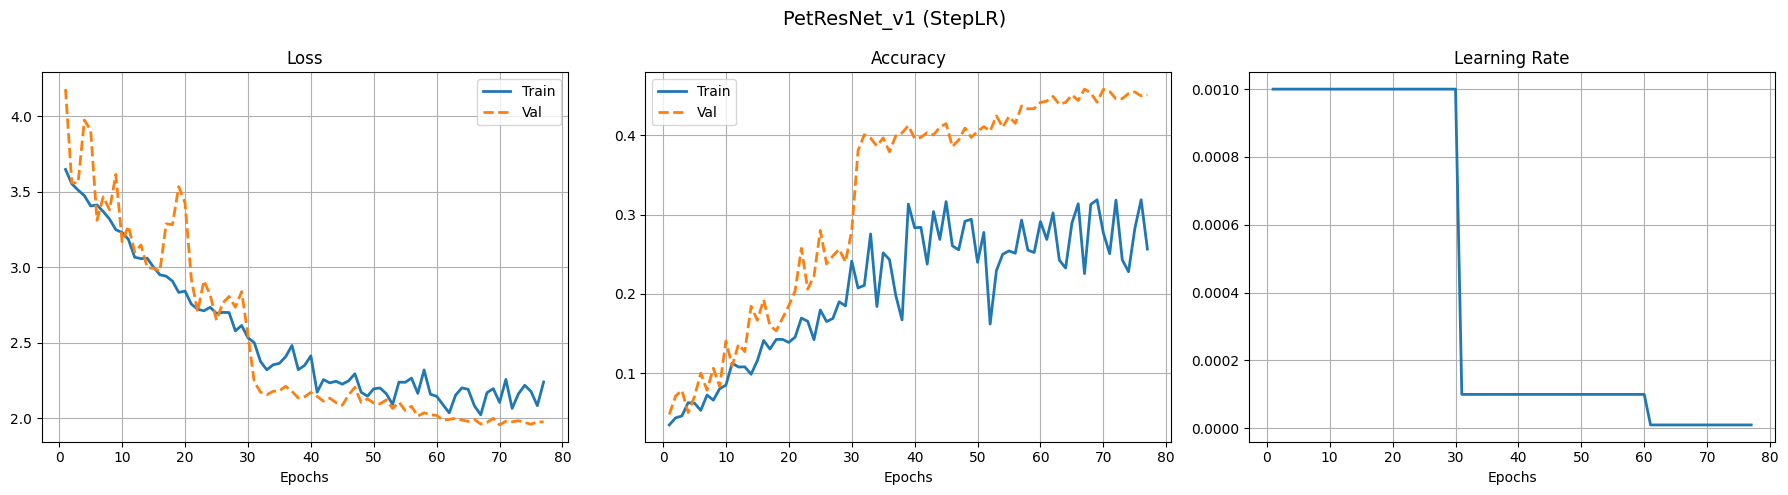

In [ ]:
model_name = "PetResNet_stepLR"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_step, best_val_step = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=0.001,
    weight_decay=0.01,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False,
    scheduler_type="step" # step scheduler
)

print(f"\nBest Validation Accuracy (StepLR): {best_val_step*100:.2f}%")
plot_summary(history_step, title="PetResNet_v1 (StepLR)")

Testing

In [ ]:
model_name = "PetResNet_stepLR"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

checkpoint = torch.load(
    f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt",
    map_location=device
)

model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_step, test_acc_step = evaluate(model, test_loader, criterion)

print(f"Test Loss (StepLR): {test_loss_step:.4f}")
print(f"Test Accuracy (StepLR): {test_acc_step*100:.2f}%")

Test Loss (StepLR): 1.8360
Test Accuracy (StepLR): 47.32%


### Observation (**StepLR**)

|  | **Best Model (Cosine LR)** | **StepLR** |
|---|---------------------------|-----------|
| **Test Loss** | 1.1250 | 1.8360 |
| **Test Accuracy (%)** | 69.58 | 47.32 |

Switching from [cosine annealing](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html) to [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html  
) causes a severe performance drop (~22% accuracy decrease).

StepLR reduces the learning rate abruptly every fixed number of epochs. In our case, this likely caused suboptimal optimization which either reducing the learning rate too aggressively or at the wrong time.

Cosine annealing, on the other hand, provides a smooth and gradual decay, which appears to help the model converge more effectively.

Conclusion: the learning rate schedule plays a major role in performance, and cosine annealing is clearly better suited for this setup.

In [ ]:
hyperparam_summary["PetResNet_v4_stepLR"] = {
    "mixup": True,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 0.01,
    "scheduler": "StepLR",
    "Validation_accuracy (%)": round(best_val_step * 100, 2),
    "test_accuracy (%)": round(test_acc_step * 100, 2),
    "epochs_trained": len(history_step["train_loss"])
}

# Table 1. **Hyperparameter ablations**

## Summary table

In [ ]:
hyperparam_df = pd.DataFrame.from_dict(hyperparam_summary,orient="index")
baseline_name = "PetResNet_v1_mixup"

# We compute validation drop against baseline
baseline_val = hyperparam_df.loc[baseline_name, "Validation_accuracy (%)"]
hyperparam_df["Val_Drop_vs_Baseline (%)"] = (baseline_val - hyperparam_df["Validation_accuracy (%)"]).round(2)
hyperparam_df = hyperparam_df.sort_values(by="Validation_accuracy (%)",ascending=False)
hyperparam_df

mixup  base_channels  dropout  learning_rate  \
PetResNet_v1_mixup             True             32      0.2          0.001   
PetResNet_v2_no_dropout        True             32      0.0          0.001   
PetResNet_v1_nomix            False             32      0.2          0.001   
PetResNet_v3_no_weight_decay   True             32      0.2          0.001   
PetResNet_v4_stepLR            True             32      0.2          0.001   

                              weight_decay        scheduler  \
PetResNet_v1_mixup                    0.01  CosineAnnealing   
PetResNet_v2_no_dropout               0.01  CosineAnnealing   
PetResNet_v1_nomix                    0.01  CosineAnnealing   
PetResNet_v3_no_weight_decay          0.00  CosineAnnealing   
PetResNet_v4_stepLR                   0.01           StepLR   

                              Validation_accuracy (%)  test_accuracy (%)  \
PetResNet_v1_mixup                              66.81              69.58   
PetResNet_v2_no_dropout                         63.60              64.07   
PetResNet_v1_nomix                              61.69              65.08   
PetResNet_v3_no_weight_decay                    52.23              57.64   
PetResNet_v4_stepLR                             45.81              47.32   

                              epochs_trained  Val_Drop_vs_Baseline (%)  
PetResNet_v1_mixup                       125                      0.00  
PetResNet_v2_no_dropout                  106                      3.21  
PetResNet_v1_nomix                        97                      5.12  
PetResNet_v3_no_weight_decay              76                     14.58  
PetResNet_v4_stepLR                       77                     21.00

###  Summary

The table clearly shows that **PetResNet_v1_mixup** is the best-performing configuration, reaching **69.58% test accuracy**.

Key observations:

- **Weight decay** is the most critical component. Removing it causes the largest drop in validation accuracy (~14.6%).
- The **learning rate scheduler** also has a major impact. Switching to StepLR severely hurts performance (~21% drop).
- **Dropout** provides meaningful regularization (~3% drop without it).
- **Mixup** improves robustness and handles the overfitting issue, though its effect is smaller compared to weight decay and scheduling.

Overall, optimization strategy (weight decay + cosine annealing) has a stronger impact than architectural tweaks. This confirms that training dynamics are just as important as model design.



---



# **B. Architectural Ablations**

## Ablation B1 - **Remove Batch Norm**

To analyze the role of normalization, BatchNorm layers are removed from the residual network while keeping depth and width unchanged.  
Batch normalization typically improves training stability and allows higher learning rates.  
This ablation tests whether normalization is essential for this dataset or whether the network can achieve similar performance without it.

In [ ]:
class ResidualBlock_NoBN(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=True)

        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, 1, stride, bias=True)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = self.dropout(out)

        out = out + identity
        out = F.relu(out)

        return out

class PetResNet_v6(nn.Module):
    def __init__(self, num_classes, base_ch=32, dropout_p=0.2):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
        )

        self.stage1 = nn.Sequential(
            ResidualBlock_NoBN(base_ch, base_ch, 1, 0.0),
            ResidualBlock_NoBN(base_ch, base_ch, 1, 0.0),
        )

        self.stage2 = nn.Sequential(
            ResidualBlock_NoBN(base_ch, base_ch*2, 2, 0.0),
            ResidualBlock_NoBN(base_ch*2, base_ch*2, 1, 0.0),
        )

        self.stage3 = nn.Sequential(
            ResidualBlock_NoBN(base_ch*2, base_ch*4, 2, 0.05),
            ResidualBlock_NoBN(base_ch*4, base_ch*4, 1, 0.05),
        )

        self.stage4 = nn.Sequential(
            ResidualBlock_NoBN(base_ch*4, base_ch*8, 2, 0.1),
            ResidualBlock_NoBN(base_ch*8, base_ch*8, 1, 0.1),
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch*8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x).flatten(1)
        x = self.head(x)
        return x

In [ ]:
model = PetResNet_v6(num_classes=num_classes, base_ch=32, dropout_p=0.20).to(device)
params_noBN = count_parameters(model)
params_noBN_m = round(params_noBN / 1e6, 3)

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v6_no_batchnorm.pt
New best model saved (PetResNet_v6_no_batchnorm) epoch 1, val acc 2.69%
Epoch 1 | Train Loss 3.6131 | Train Acc 2.13% | Val Loss 3.6113 | Val Acc 2.69%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v6_no_batchnorm.pt
New best model saved (PetResNet_v6_no_batchnorm) epoch 2, val acc 2.86%
Epoch 2 | Train Loss 3.6123 | Train Acc 2.59% | Val Loss 3.6110 | Val Acc 2.86%
Epoch 3 | Train Loss 3.6122 | Train Acc 2.69% | Val Loss 3.6112 | Val Acc 2.26%
Epoch 4 | Train Loss 3.6119 | Train Acc 2.80% | Val Loss 3.6057 | Val Acc 2.10%
Epoch 5 | Train Loss 3.6079 | Train Acc 3.02% | Val Loss 3.6114 | Val Acc 1.83%
Epoch 6 | Train Loss 3.6124 | Train Acc 2.51% | Val Loss 3.6055 | Val Acc 2.64%
Epoch 7 | Train Loss 3.6046 | Train Acc 2.75% | Val Loss 3.5985 | Val Acc 2.86%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v6_no_batchnorm.pt
New best model saved (PetResN

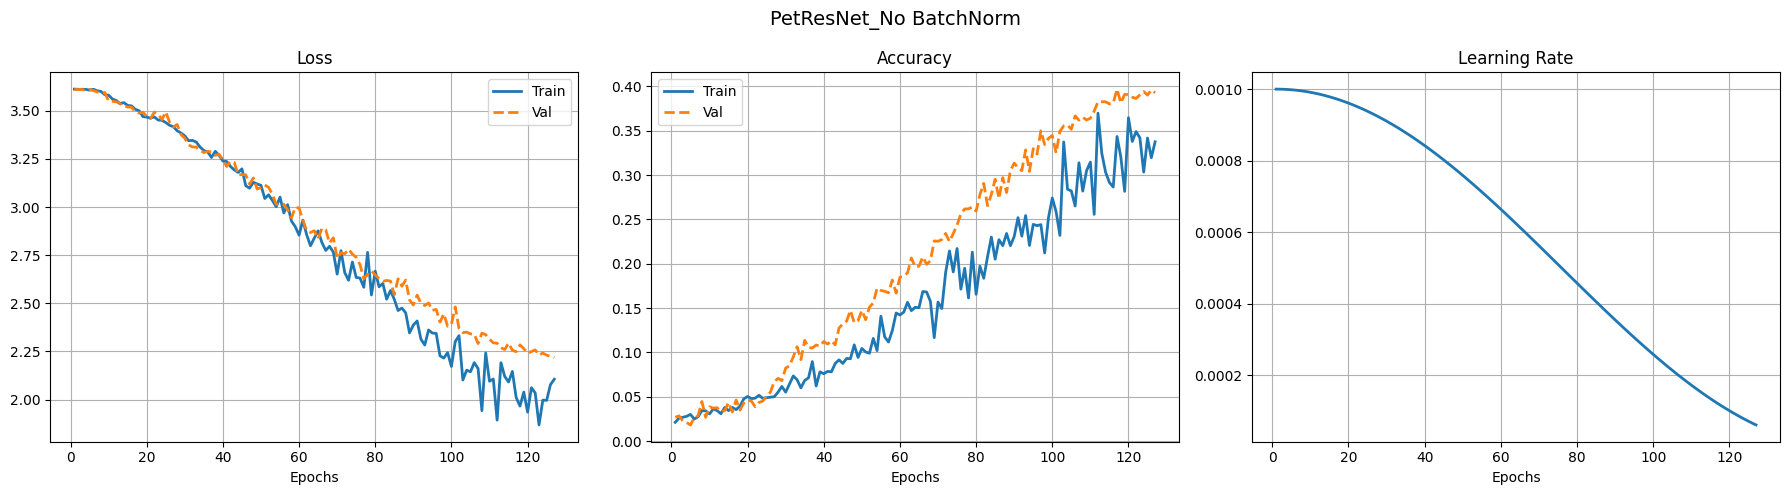

In [ ]:
model_name = "PetResNet_v6_no_batchnorm"

model = PetResNet_v6(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_v6, best_val_v6 = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\nAblation (No BatchNorm) Best Validation Accuracy: {best_val_v6*100:.2f}%")

plot_summary(
    history_v6,
    title="PetResNet_No BatchNorm"
)

In [ ]:
model_name = "PetResNet_v6_no_batchnorm"

model = PetResNet_v6(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Load best saved weights
checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_v6, test_acc_v6 = evaluate(model, test_loader, criterion)

print(f"Test Loss (No batch norm): {test_loss_v6:.4f}")
print(f"Test Accuracy (No batch norm): {test_acc_v6 * 100:.2f}%")

Test Loss (No batch norm): 2.0444
Test Accuracy (No batch norm): 43.55%


### Observation: (**Removing Batch Normalization**)

|  | **Best Model** | **No BatchNorm** |
|---|---------------|------------------|
| **Test Loss** | 1.1250 | 2.0444 |
| **Test Accuracy (%)** | 69.58 | 43.55 |

Removing Batch Normalization causes a massive performance drop (~26% accuracy decrease) and a very high test loss.

BatchNorm (Ioffe & Szegedy, 2015 - https://arxiv.org/abs/1502.03167) stabilizes training by normalizing intermediate activations. This reduces internal covariate shift and allows higher learning rates and faster convergence.

Without BatchNorm:
- Training becomes less stable.
- Gradients are less well-behaved.
- Optimization becomes significantly harder.
- The model generalizes very poorly.

This is a strong architectural degradation observed so far.

Conclusion: Batch Normalization is absolutely critical in this architecture. Its removal severely harms optimization and generalization.

In [ ]:
# NO batch norm
architecture_summary["PetResNet_v6_no_batchnorm"] = {
    "residual_connections": True,
    "batch_norm": False,
    "blocks_per_stage": 2,
    "num_stages": 4,
    "base_channels": 32,
    "Parameters (M)": params_noBN_m,
    "Validation_accuracy (%)": round(best_val_v6 * 100, 2),
    "test_accuracy (%)": round(test_acc_v6 * 100, 2),
    "epochs_trained": len(history_v6["train_loss"])
}

##

## Ablation B2. **Half-Depth Model (One Block per Stage)**

In this experiment, the number of residual blocks per stage is reduced from two to one, effectively cutting the total depth of the network in half.  
The residual connections and overall architecture remain unchanged, so the only difference is the reduced depth.  
The goal of this ablation is to evaluate whether having deeper hierarchical feature extraction significantly improves performance on this dataset.  
If accuracy drops compared to the baseline model, it would suggest that deeper representations contribute meaningfully to classification performance.

In [ ]:
class ResidualBlock(nn.Module):
    """
    The residual block with optional downsampling.
    """

    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

        # skip connection to match dimensions if neded
        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.dropout(out)

        out = out + identity
        out = F.relu(out, inplace=True)

        return out

# Half-Depth Version of PetResNet

class PetResNet_HalfDepth(nn.Module):
    """
    Half-depth version of the baseline model.
    Only one residual block per stage instead of two.
    """

    def __init__(self, num_classes, base_ch=32, dropout_p=0.10):
        super().__init__()

        # Stem (unchanged)
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        # Stage 1 (1 block instead of 2)
        self.stage1 = nn.Sequential(
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
        )

        # Stage 2
        self.stage2 = nn.Sequential(
            ResidualBlock(base_ch, base_ch*2, stride=2, dropout_p=0.0),
        )

        # Stage 3
        self.stage3 = nn.Sequential(
            ResidualBlock(base_ch*2, base_ch*4, stride=2, dropout_p=0.05),
        )

        # Stage 4
        self.stage4 = nn.Sequential(
            ResidualBlock(base_ch*4, base_ch*8, stride=2, dropout_p=0.10),
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head sam as before
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch*8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = self.head(x)

        return x

In [ ]:
model = PetResNet_HalfDepth(num_classes=num_classes, base_ch=32, dropout_p=0.20).to(device)
params_halfdepth = count_parameters(model)
params_halfdepth_m = round(params_halfdepth/ 1e6, 3)

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v5_HalfDepth.pt
New best model saved (PetResNet_v5_HalfDepth) epoch 1, val acc 5.99%
Epoch 1 | Train Loss 3.6016 | Train Acc 4.04% | Val Loss 3.5193 | Val Acc 5.99%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v5_HalfDepth.pt
New best model saved (PetResNet_v5_HalfDepth) epoch 2, val acc 7.92%
Epoch 2 | Train Loss 3.5026 | Train Acc 4.28% | Val Loss 3.4051 | Val Acc 7.92%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v5_HalfDepth.pt
New best model saved (PetResNet_v5_HalfDepth) epoch 3, val acc 8.57%
Epoch 3 | Train Loss 3.4363 | Train Acc 5.74% | Val Loss 3.4611 | Val Acc 8.57%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v5_HalfDepth.pt
New best model saved (PetResNet_v5_HalfDepth) epoch 4, val acc 9.21%
Epoch 4 | Train Loss 3.3760 | Train Acc 6.09% | Val Loss 3.3653 | Val Acc 9.21%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/

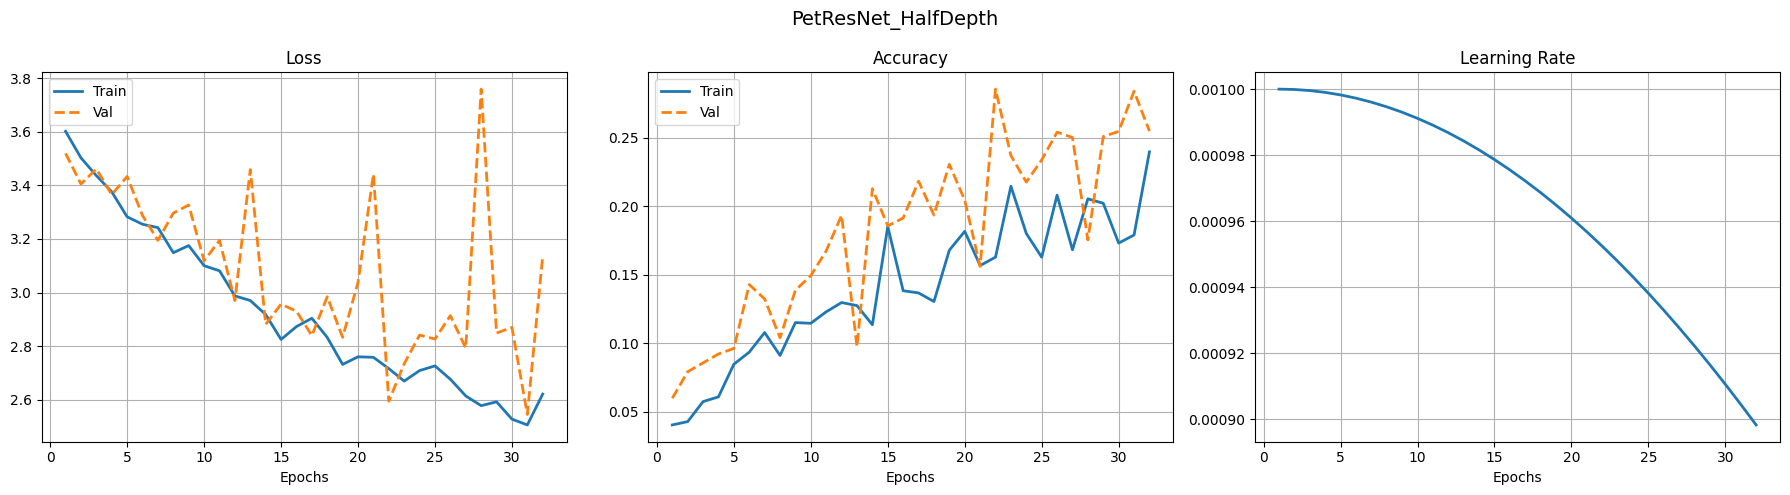

In [ ]:
model_name = "PetResNet_v5_HalfDepth"

model = PetResNet_HalfDepth(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_half, best_val_half = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\nBest Validation Accuracy (HalfDepth): {best_val_half*100:.2f}%")
plot_summary(history_half, title="PetResNet_HalfDepth")

Testing

In [ ]:
model_name = "PetResNet_v5_HalfDepth"

model = PetResNet_HalfDepth(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Load best saved weights
checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_half, test_acc_half = evaluate(model, test_loader, criterion)

print(f"Test Loss (HalfDepth): {test_loss_half:.4f}")
print(f"Test Accuracy (HalfDepth): {test_acc_half * 100:.2f}%")

Test Loss (HalfDepth): 2.4291
Test Accuracy (HalfDepth): 30.87%


### Observations (**Network depth- HalfDepth**)

|  | **Best Model** | **HalfDepth Model** |
|---|---------------|--------------------|
| **Test Loss** | 1.1250 | 2.4291 |
| **Test Accuracy (%)** | 69.58 | 30.87 |

Reducing the model to only one residual block per stage causes a dramatic collapse in performance (~39% drop in accuracy).

This shows that the original depth is not excessive - it is necessary. With fewer layers:
- The model capacity becomes too limited.
- Feature representations are too shallow.
- The network fails to extract sufficiently abstract breed-level features.

The very high test loss confirms that predictions are both inaccurate and poorly calibrated.

Conclusion: the baseline depth is justified. The model was not over-parameterized; reducing depth severely harms representation quality and generalization.

In [ ]:
# half depth model summary
checkpoint_half = torch.load(
    "/content/drive/MyDrive/ipcv_checkpoints/PetResNet_v5_HalfDepth.pt",
    map_location=device
)

best_val_half = checkpoint_half["best_val_acc"]
history_half = checkpoint_half["history"]

architecture_summary["PetResNet_HalfDepth"] = {
    "residual_connections": True,
    "batch_norm": True,
    "blocks_per_stage": 1,
    "num_stages": 4,
    "base_channels": 32,
    "Parameters (M)": params_halfdepth_m,
    "Validation_accuracy (%)": round(best_val_half * 100, 2),
    "test_accuracy (%)": round(test_acc_half * 100, 2),
    "epochs_trained": len(history_half["train_loss"])
}

## Ablation B3 - **Remove Skip Connections**

Residual connections are the key idea behind ResNet and were proposed to help deeper networks train more effectively [(He et al., 2015)](https://arxiv.org/abs/1512.03385).  
In this experiment, the skip connection is removed while keeping everything else in the architecture unchanged.  
This means the model is no longer a ResNet-style network but a standard deep CNN.  
By comparing performance with the baseline model, we can understand how important residual learning is for this task.

In [ ]:
class PetCNN_noSkip(nn.Module):
    """
    Same structure as ResidualBlock but without the residual addition.
    This makes the model a plain deep CNN instead of the esNet-style model we experimented on.
    """
    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_ch, out_ch,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(
            out_ch, out_ch,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.dropout(out)

        out = F.relu(out, inplace=True)

        return out


class PetCNN(nn.Module):
    """
    Architecture identical to PetResNet_v1 but without residual connections.
    """

    def __init__(self, num_classes, base_ch=32, dropout_p=0.10):
        super().__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        # Stage 1
        self.stage1 = nn.Sequential(
            PetCNN_noSkip(base_ch, base_ch, stride=1, dropout_p=0.0),
            PetCNN_noSkip(base_ch, base_ch, stride=1, dropout_p=0.0),
        )

        # Stage 2
        self.stage2 = nn.Sequential(
            PetCNN_noSkip(base_ch, base_ch * 2, stride=2, dropout_p=0.0),
            PetCNN_noSkip(base_ch * 2, base_ch * 2, stride=1, dropout_p=0.0),
        )

        # Stage 3
        self.stage3 = nn.Sequential(
            PetCNN_noSkip(base_ch * 2, base_ch * 4, stride=2, dropout_p=0.05),
            PetCNN_noSkip(base_ch * 4, base_ch * 4, stride=1, dropout_p=0.05),
        )

        # Stage 4
        self.stage4 = nn.Sequential(
            PetCNN_noSkip(base_ch * 4, base_ch * 8, stride=2, dropout_p=0.10),
            PetCNN_noSkip(base_ch * 8, base_ch * 8, stride=1, dropout_p=0.10),
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch * 8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        return x

In [ ]:
model = PetCNN(num_classes=num_classes, base_ch=32, dropout_p=0.20).to(device)
params_noskip = count_parameters(model)
params_noskip_m = round(params_noskip / 1e6, 3)

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetCNN_NoSkip.pt
New best model saved (PetCNN_NoSkip) epoch 1, val acc 4.10%
Epoch 1 | Train Loss 3.6157 | Train Acc 2.83% | Val Loss 5.0587 | Val Acc 4.10%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetCNN_NoSkip.pt
New best model saved (PetCNN_NoSkip) epoch 2, val acc 5.33%
Epoch 2 | Train Loss 3.5755 | Train Acc 3.53% | Val Loss 3.5192 | Val Acc 5.33%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetCNN_NoSkip.pt
New best model saved (PetCNN_NoSkip) epoch 3, val acc 6.57%
Epoch 3 | Train Loss 3.5281 | Train Acc 4.61% | Val Loss 3.5086 | Val Acc 6.57%
Epoch 4 | Train Loss 3.5029 | Train Acc 3.94% | Val Loss 3.5926 | Val Acc 6.09%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetCNN_NoSkip.pt
New best model saved (PetCNN_NoSkip) epoch 5, val acc 7.41%
Epoch 5 | Train Loss 3.4871 | Train Acc 4.93% | Val Loss 3.4115 | Val Acc 7.41%
Checkpoint saved to /content/drive/MyDrive/ipcv_chec

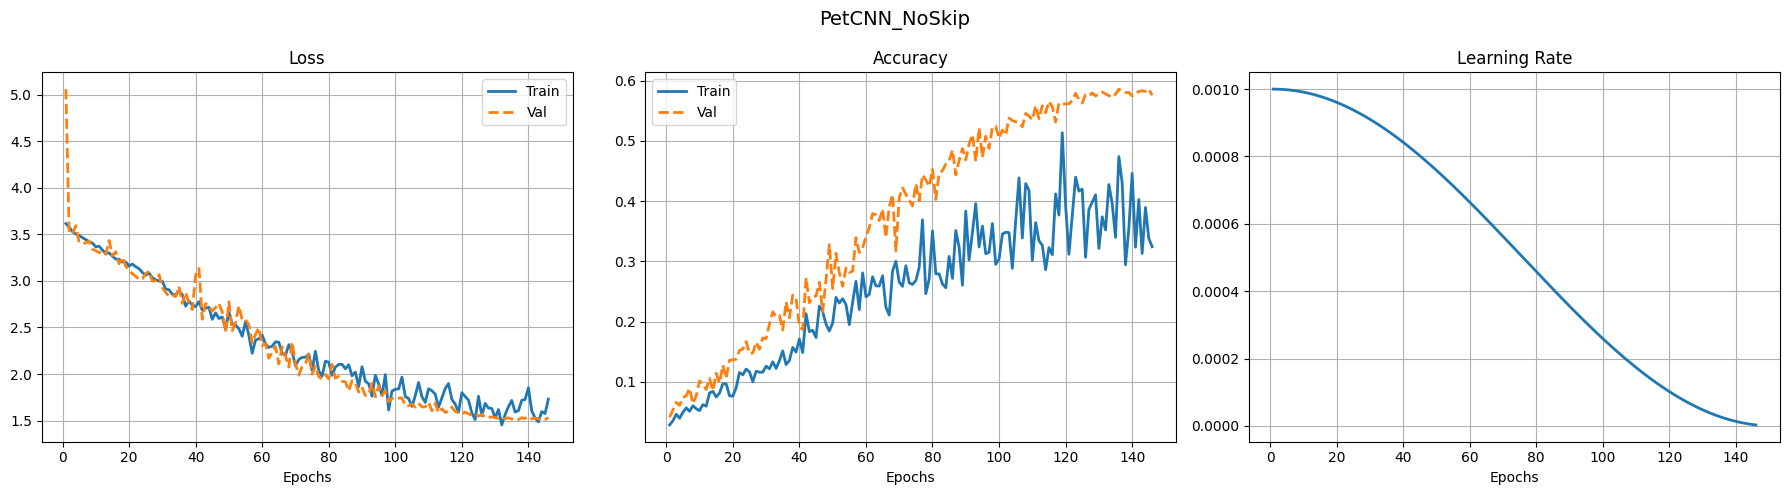

In [ ]:
model_name = "PetCNN_NoSkip"

model = PetCNN(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_noskip, best_val_noskip = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\nBest Validation Accuracy (NoSkip): {best_val_noskip*100:.2f}%")
plot_summary(history_noskip, title="PetCNN_NoSkip")

In [ ]:
model_name = "PetCNN_NoSkip"

model = PetCNN(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# lod best saved weights
checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_noskip, test_acc_noskip = evaluate(model, test_loader, criterion)

print(f"Test Loss (NoSkip): {test_loss_noskip:.4f}")
print(f"Test Accuracy (NoSkip): {test_acc_noskip * 100:.2f}%")

Test Loss (NoSkip): 1.3999
Test Accuracy (NoSkip): 60.95%


### Observation: **Removing Residual Connections (NoSkip)**

|  | **Best Model** | **NoSkip (Plain CNN)** |
|---|---------------|------------------------|
| **Test Loss** | 1.1250 | 1.3999 |
| **Test Accuracy (%)** | 69.58 | 60.95 |

Removing the residual connections drops accuracy by ~9% and increases test loss.

The architecture remains identical in depth and width, but without the skip addition. This confirms that the performance gain comes specifically from **residual learning**, not just depth.

Residual connections improve gradient flow and make optimization easier (He et al., 2016 - https://arxiv.org/abs/1512.03385).  
Without them, training can become stable and generalization weakens.

Conclusion: residual connections provide a clear and measurable benefit, even in moderately deep networks.

In [ ]:
# summary for the no skip model
checkpoint_noskip = torch.load(
    "/content/drive/MyDrive/ipcv_checkpoints/PetCNN_NoSkip.pt",
    map_location=device
)

best_val_noskip = checkpoint_noskip["best_val_acc"]
history_noskip = checkpoint_noskip["history"]

architecture_summary["PetCNN_NoSkip"] = {
    "residual_connections": False,
    "batch_norm": True,
    "blocks_per_stage": 2,
    "num_stages": 4,
    "base_channels": 32,
    "Parameters (M)": params_noskip_m,
    "Validation_accuracy (%)": round(best_val_noskip * 100, 2),
    "test_accuracy (%)": round(test_acc_noskip * 100, 2),
    "epochs_trained": len(history_noskip["train_loss"])
}

## Ablation B4 - **Remove Stage 4**

In [ ]:
class PetResNet_3Stage(nn.Module):
    """
    Still the ResNet architecture with Stage 4 removed.
    The network now contains 3 stages instead of 4.
    """

    def __init__(self, num_classes, base_ch=32, dropout_p=0.2):
        super().__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        # Stage 1
        self.stage1 = nn.Sequential(
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
        )

        # Stage 2
        self.stage2 = nn.Sequential(
            ResidualBlock(base_ch, base_ch * 2, stride=2, dropout_p=0.0),
            ResidualBlock(base_ch * 2, base_ch * 2, stride=1, dropout_p=0.0),
        )

        # Stage 3 (the final stage now)
        self.stage3 = nn.Sequential(
            ResidualBlock(base_ch * 2, base_ch * 4, stride=2, dropout_p=0.05),
            ResidualBlock(base_ch * 4, base_ch * 4, stride=1, dropout_p=0.05),
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # important: input now base_ch * 4 (not *8)
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch * 4, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.head(x)

        return x

In [ ]:
model_temp = PetResNet_3Stage(num_classes=num_classes, base_ch=32, dropout_p=0.2)
params_3stage_m = round(count_parameters(model_temp) / 1e6, 3)

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_3Stage.pt
New best model saved (PetResNet_3Stage) epoch 1, val acc 5.66%
Epoch 1 | Train Loss 3.6225 | Train Acc 3.99% | Val Loss 3.5515 | Val Acc 5.66%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_3Stage.pt
New best model saved (PetResNet_3Stage) epoch 2, val acc 7.38%
Epoch 2 | Train Loss 3.5093 | Train Acc 4.98% | Val Loss 3.4652 | Val Acc 7.38%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_3Stage.pt
New best model saved (PetResNet_3Stage) epoch 3, val acc 9.11%
Epoch 3 | Train Loss 3.4693 | Train Acc 5.55% | Val Loss 3.4507 | Val Acc 9.11%
Epoch 4 | Train Loss 3.4375 | Train Acc 5.77% | Val Loss 3.4486 | Val Acc 8.24%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_3Stage.pt
New best model saved (PetResNet_3Stage) epoch 5, val acc 9.19%
Epoch 5 | Train Loss 3.4056 | Train Acc 5.44% | Val Loss 3.4443 | Val Acc 9.19%
Epoch 6 | Train Loss 3.3777 

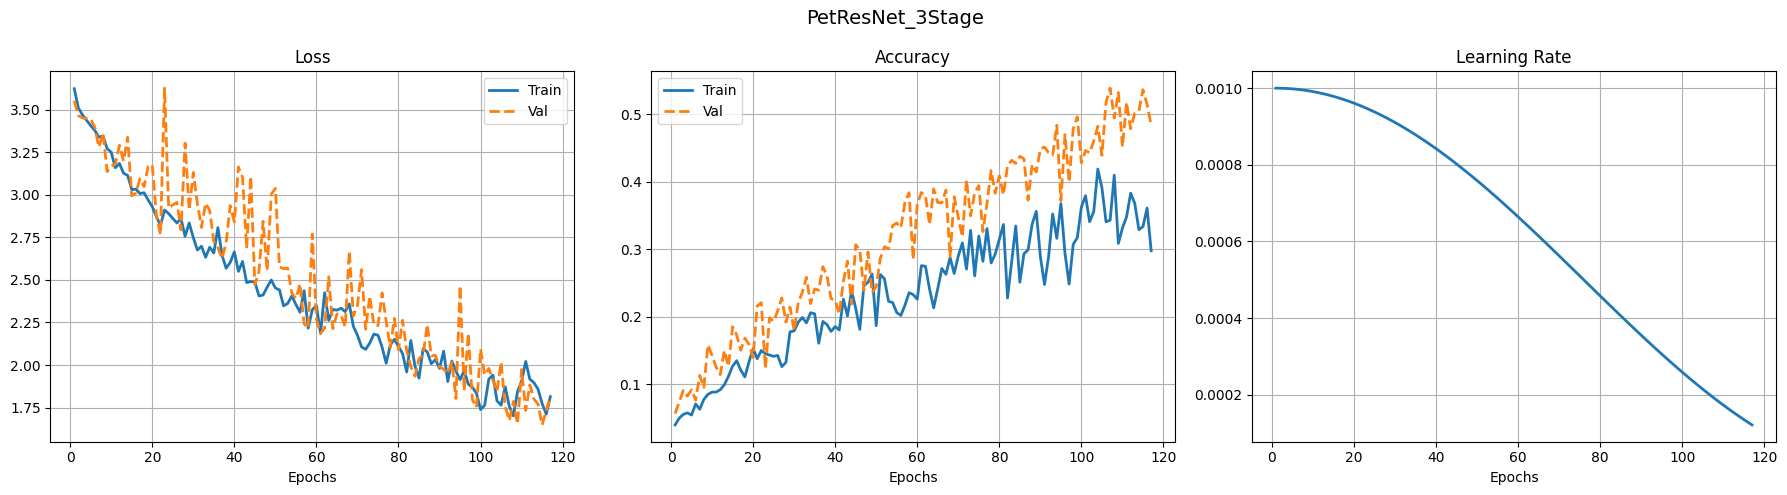

In [ ]:
model_name = "PetResNet_3Stage"

model = PetResNet_3Stage(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_3stage, best_val_3stage = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=0.001,
    weight_decay=0.01,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\nBest Validation Accuracy (3Stage): {best_val_3stage*100:.2f}%")
plot_summary(history_3stage, title="PetResNet_3Stage")

Testing

In [ ]:
model_name = "PetResNet_3Stage"

model = PetResNet_3Stage(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

checkpoint = torch.load(
    f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt",
    map_location=device
)

model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_3stage, test_acc_3stage = evaluate(model, test_loader, criterion)

print(f"Test Loss (3Stage): {test_loss_3stage:.4f}")
print(f"Test Accuracy (3Stage): {test_acc_3stage*100:.2f}%")

Test Loss (3Stage): 1.5711
Test Accuracy (3Stage): 53.66%


### Observation: **Removing Stage 4 (3-Stage Model)**

|  | **Best Model** | **3-Stage Model** |
|---|---------------|------------------|
| **Test Loss** | 1.1250 | 1.5711 |
| **Test Accuracy (%)** | 69.58 | 53.66 |

Removing the final stage causes a significant drop (~16% accuracy decrease).

Stage 4 is responsible for:
- Further spatial downsampling,
- Increasing channel depth (feature richness),
- Learning higher-level abstract representations.

Without it, the network becomes shallower in representational capacity.  
Although training still works, the model cannot extract sufficiently discriminative features for fine-grained breed classification.

The higher test loss also indicates weaker confidence and poorer generalization.

Conclusion: this tells us the fourth stage is not redundant and it plays a key role in capturing high-level semantic features.

In [ ]:
architecture_summary["PetResNet_3Stage"] = {
    "residual_connections": True,
    "batch_norm": True,
    "blocks_per_stage": 2,
    "num_stages": 3,   #
    "base_channels": 32,
    "Parameters (M)": params_3stage_m,
    "Validation_accuracy (%)": round(best_val_3stage * 100, 2),
    "test_accuracy (%)": round(test_acc_3stage * 100, 2),
    "epochs_trained": len(history_3stage["train_loss"])
}

# **Best Model Analysis**

# Table 2. **Architectural ablations**



## Summary table

In [ ]:
arch_df = pd.DataFrame.from_dict(architecture_summary,orient="index")
baseline_name = "PetResNet_v1_mixup"

# We compute validation drop against baseline
baseline_val = arch_df.loc[baseline_name, "Validation_accuracy (%)"]
arch_df["Val_Drop_vs_Baseline (%)"] = (baseline_val - arch_df["Validation_accuracy (%)"]).round(2)
arch_df = arch_df.sort_values(by="Validation_accuracy (%)",ascending=False)
arch_df

residual_connections  batch_norm  blocks_per_stage  \
PetResNet_v1_mixup                         True        True                 2   
PetCNN_NoSkip                             False        True                 2   
PetResNet_3Stage                           True        True                 2   
PetResNet_v6_no_batchnorm                  True       False                 2   
PetResNet_HalfDepth                        True        True                 1   

                           num_stages  base_channels  Parameters (M)  \
PetResNet_v1_mixup                  4             32           2.805   
PetCNN_NoSkip                       4             32           2.761   
PetResNet_3Stage                    3             32           0.700   
PetResNet_v6_no_batchnorm           4             32           2.802   
PetResNet_HalfDepth                 4             32           1.236   

                           Validation_accuracy (%)  test_accuracy (%)  \
PetResNet_v1_mixup                           66.81              69.58   
PetCNN_NoSkip                                58.59              60.95   
PetResNet_3Stage                             53.90              53.66   
PetResNet_v6_no_batchnorm                    39.69              43.55   
PetResNet_HalfDepth                          28.53              30.87   

                           epochs_trained  Val_Drop_vs_Baseline (%)  
PetResNet_v1_mixup                    125                      0.00  
PetCNN_NoSkip                         136                      8.22  
PetResNet_3Stage                      117                     12.91  
PetResNet_v6_no_batchnorm             127                     27.12  
PetResNet_HalfDepth                    22                     38.28

Analyzing Model: PetResNet_v1_mixup

Test Accuracy: 69.58%
Test Loss: 1.1250


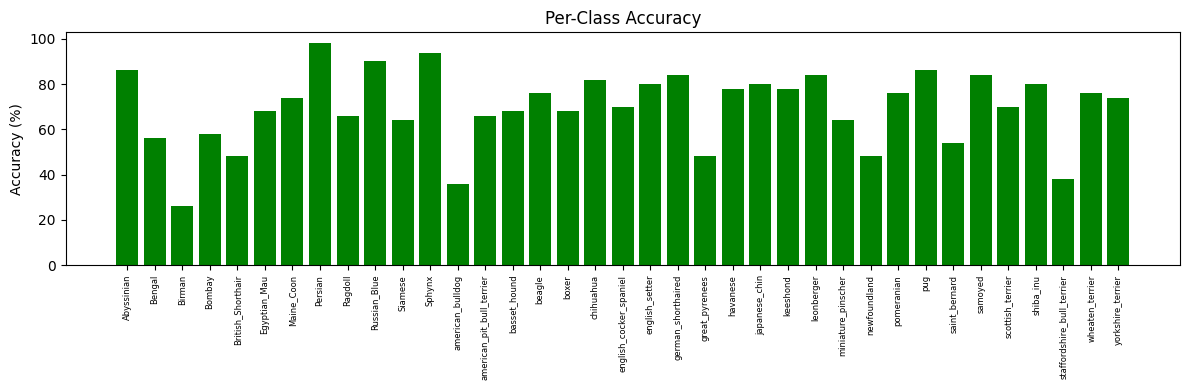

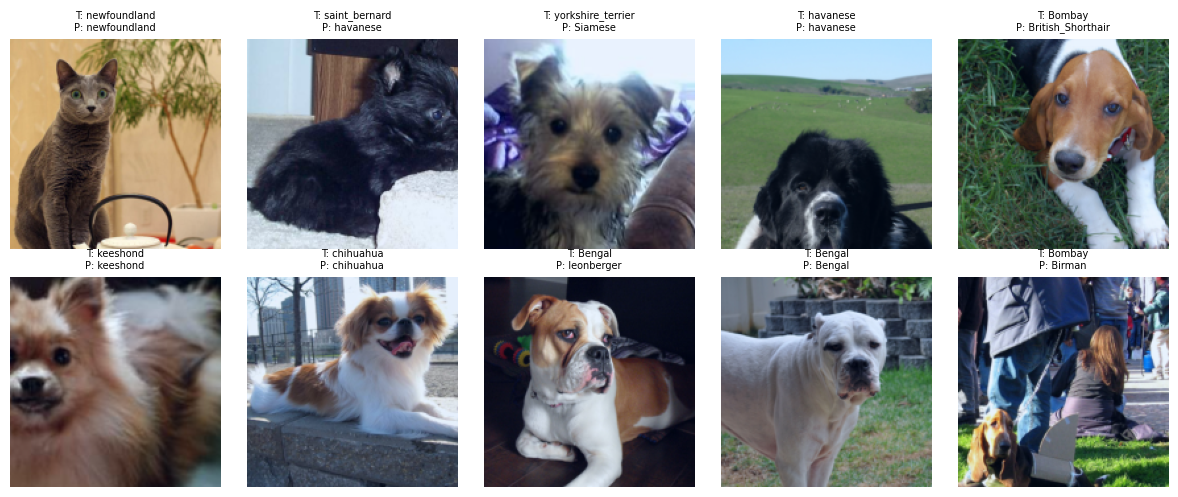

In [ ]:
final_model_analysis(
    model_class=PetResNet_v1,
    model_name="PetResNet_v1_mixup",
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2,
    test_loader=test_loader,
    device=device,
    num_samples=10
)

# **Conclusion**

We implemented a full classification pipeline including preprocessing, augmentation, model design, optimization strategy, and controlled ablation studies.  
The final selected model, **PetResNet_v1 with mixup**, achieved:

- **Validation Accuracy:** $66.81\%$
- **Test Accuracy:** $69.58\%$  
- **Test Loss:** $1.1250\$    
- ~2.8M parameters  

This confirms that the chosen architecture and training strategy are well balanced for a ~7k image dataset.

### What mattered most

From the hyperparameter ablations:

- Adding **mixup** helped not only improve the accuracy of the base model, but it mitigated the overfitting issue, which was the main reason we used it as our main best model.
- Removing **weight decay** dropped test accuracy from 69.58% to $57.64\%$. This shows L2 regularization is essential.
- Switching from **CosineAnnealingLR to StepLR** reduced accuracy to $47.32\%$, proving that smooth learning rate decay is crucial for convergence.
- Removing **dropout** reduced accuracy to $60.07\%$, confirming its role in regularization.


From the architectural ablations:

- Removing **BatchNorm** collapsed performance to $43.55\%$. This was the most critical architectural component for stable optimization.
- Removing **residual connections** reduced accuracy to $60.95\%$, confirming that skip connections improve gradient flow and representation learning.
- Removing an entire stage (3-stage model) reduced accuracy to $53.66\%$, showing that deeper semantic features are necessary.
- Cutting depth in half caused performance to collapse to $30.87\%$, meaning the baseline capacity is justified and not excessive.

### **Per-Class Behavior**

The per-class accuracy plot shows strong variation across breeds. Some classes reach above $85-90\%$ accuracy, while others fall below $30\%$. This suggests that:

- Certain breeds are visually distinctive and easier to separate.
- Others are visually similar, leading to confusion.
- **Birman** and the **American-bulldog** had the lowest accuracy falling below $30\%$ and $40\%$, respectively
- **Abysinnian**, **Persian**, **Sphynx** and **Russian blue** had the high accuracies well above $80\%$, with Persian being the highest at above $90\%$ acc.

### **Overall Takeaway**

The final model performs well because it combines:

- Proper normalization and augmentation  
- Residual learning  
- Batch normalization  
- Sufficient depth  
- Strong regularization  
- A well-chosen learning rate schedule  

The ablation results clearly show that performance is not random. Each component contributes measurably. The final configuration is therefore not just empirically good, but we believe structurally justified.

**End of Experiment (Part 1).**



---



---



# **Part 2: fine-tune an existing network**

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

We perform transfer learning using a pretrained ResNet18. All images were resized to 224 × 224 pixels to match the input requirements of ResNet18 and normalized using the ImageNet mean and standard deviation, ensuring compatibility with the pretrained weights.

In [ ]:
hyperparameters_part2  = {
    "batch_size": 64,
    'mean_imagenet': [0.485, 0.456, 0.406],
    'std_imagenet' : [0.229, 0.224, 0.225],
    'size_imagenet' : 224,
    'num_workers' : 2,
    'num_epochs' : 30,
    'lr' : 1e-3,
    'min_lr' : 1e-7,
    'patience_scheduler' : 2,
    'factor_scheduler' : 0.5,
    'wd' : 1e-2,
    'patience' : 10,
    'alpha_mixup' : 0.4
    }

train_transform2 = transforms.Compose([
    transforms.RandomResizedCrop(
        size= hyperparameters_part2['size_imagenet'],
        scale=(0.7, 1.0),
        ratio=(0.75, 1.33)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = hyperparameters_part2['mean_imagenet'],
        std = hyperparameters_part2['std_imagenet']
    ),
])

test_transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(hyperparameters_part2['size_imagenet']),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = hyperparameters_part2['mean_imagenet'],
        std = hyperparameters_part2['std_imagenet']
    ),
])

In [ ]:
train_dataset2 = OxfordPetDataset(
    split="train",
    transform=train_transform2
)

test_dataset2 = OxfordPetDataset(
    split="test",
    transform=test_transform2
)

val_dataset2 = OxfordPetDataset(
    split="val",
    transform=test_transform2
)

num_classes = train_dataset2.get_num_classes()
print(num_classes)

37


For the transfer learning stage, we employed the ReduceLROnPlateau scheduler, which adaptively adjusts the learning rate based on the validation loss. This choice is particularly appropriate for transfer learning, where the model often converges quickly and may reach performance plateaus early. By reducing the learning rate when the validation loss ceases to improve, the scheduler enables finer optimization and helps prevent overfitting while maintaining training stability.

https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html


In [ ]:
class TrainerTransfer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_set,
        val_set,
        test_set,
        device: torch.device,
        hyperparameters: dict
    ) -> None:

        # Dataloaders
        self.train_loader = DataLoader(
            train_set,
            batch_size=hyperparameters.get("batch_size", 32),
            shuffle=True,
            num_workers=hyperparameters.get("num_workers", 2),
            pin_memory=True
        )

        self.val_loader = DataLoader(
            val_set,
            batch_size=hyperparameters.get("batch_size", 32),
            shuffle=False,
            num_workers=hyperparameters.get("num_workers", 2),
            pin_memory=True
        )

        self.test_loader = DataLoader(
            test_set,
            batch_size=hyperparameters.get("batch_size", 32),
            shuffle=False,
            num_workers=hyperparameters.get("num_workers", 2),
            pin_memory=True
        )

        self.device = device
        self.model = model.to(device)
        self.num_classes = train_set.get_num_classes()
        self._num_epochs = hyperparameters.get("num_epochs", 1)

        # Regularization
        self.mixup_alpha = hyperparameters.get("mixup_alpha", 0.2)
        self.use_mixup = self.mixup_alpha > 0
        self.patience = hyperparameters.get("patience", 5)

        # Optimizer (initial build)
        self._base_lr = hyperparameters.get("lr", 1e-3)
        self._base_wd = hyperparameters.get("wd", 0.0)

        self.optimizer = AdamW(
            (p for p in self.model.parameters() if p.requires_grad),
            lr=self._base_lr,
            weight_decay=self._base_wd)


        # Scheduler
        self._min_lr = hyperparameters.get("min_lr", 1e-7)
        self._patience_scheduler = hyperparameters.get("patience_scheduler", 2)
        self._factor_scheduler = hyperparameters.get("factor_scheduler", 0.2)

        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            factor=self._factor_scheduler,
            patience= self._patience_scheduler,
            min_lr=self._min_lr,
        )

        # Early stopping + tracking
        self.best_val_acc = 0.0
        self.best_val_loss = float("inf")
        self.epochs_no_improve = 0

        # Checkpoints
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

        # History
        self.history_train_loss = []
        self.history_train_acc = []
        self.history_val_loss = []
        self.history_val_acc = []
        self.history_lr = []

    @property
    def lr(self) -> float:
        return self.optimizer.param_groups[0]["lr"]
    @lr.setter
    def lr(self, value: float) -> None:
        if value <= 0:
            raise ValueError("Learning rate must be > 0")

        for param_group in self.optimizer.param_groups:
            param_group["lr"] = value

        self._rebuild_optimizer()


    @property
    def wd(self) -> float:
        return self.optimizer.param_groups[0]["weight_decay"]

    @wd.setter
    def wd(self, value: float) -> None:
        if value < 0:
            raise ValueError("Weight decay  must be >= 0")

        for param_group in self.optimizer.param_groups:
            param_group["weight_decay"] = value

        self._rebuild_optimizer()

    @property
    def num_epochs(self) -> int:
        return self._num_epochs

    @num_epochs.setter
    def num_epochs(self, value: int) -> None:
        if value <= 0:
            raise ValueError("Number of epochs must be > 0")
        self._num_epochs = value

    def _rebuild_optimizer(self) -> None:
        """
        Rebuild optimizer ONLY with trainable parameters.
        Must be called after freeze/unfreeze.
        Also rebuilds ReduceLROnPlateau because it is tied to the optimizer.
        """

        # Preserve current optimizer hyperparameters
        current_lr = self.lr
        current_wd = self.wd

        # Collect ONLY trainable parameters
        trainable_params = [
            p for p in self.model.parameters() if p.requires_grad
        ]

        # Safety check
        if len(trainable_params) == 0:
            raise ValueError(
                "No trainable parameters found"
            )

        # Rebuild optimizer with trainable params only
        self.optimizer = AdamW(
            trainable_params,
            lr=current_lr,
            weight_decay=current_wd,
        )

        # Rebuild scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            factor=self._factor_scheduler,
            patience=self._patience_scheduler,
            min_lr=self._min_lr,
        )

        print("Optimizer and scheduler rebuilt with trainable parameters only.")

    def freeze_backbone(self) -> None:
        """Freeze all layers except classifier (fc)."""
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True

        self._rebuild_optimizer()
        print("Backbone frozen. Training only classifier.")

    def unfreeze_all(self) -> None:
        """Unfreeze all model parameters."""
        for param in self.model.parameters():
            param.requires_grad = True

        self._rebuild_optimizer()
        print("All model parameters are now trainable.")

    def unfreeze_fc_layer4(self) -> None:
        """Unfreeze layer 4 and classifier."""

        for param in model.parameters():
            param.requires_grad = False

        for param in model.layer4.parameters():
            param.requires_grad = True

        for param in model.fc.parameters():
            param.requires_grad = True

        self._rebuild_optimizer()
        print("Training only classifier and layer 4")

    @property
    def mixup_alpha(self) -> float:
        return self._mixup_alpha
    @mixup_alpha.setter
    def mixup_alpha(self, value: float) -> None:
        self._mixup_alpha = value
        self.use_mixup = self._mixup_alpha > 0

    def _mixup(self, x, y):
        if self.mixup_alpha <= 0:
            return x, y, None, None, 1.0

        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(self.device)

        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]

        return mixed_x, y_a, y_b, lam

    def _mixup_loss(self, pred, y_a, y_b, lam):
        return lam * F.cross_entropy(pred, y_a) + (1 - lam) * F.cross_entropy(pred, y_b)

    def train(self, file_weights: str = "best_model.pt"):

        self._best_weights_name = file_weights
        self.epochs_no_improve = 0
        self.best_val_acc = 0.0
        self.best_val_loss = float("inf")
        self.history_train_loss = []
        self.history_train_acc = []
        self.history_val_loss = []
        self.history_val_acc = []
        self.history_lr = []


        for epoch in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                if self.use_mixup:
                    imgs, y_a, y_b, lam = self._mixup(imgs, labels)
                    pred = self.model(imgs)
                    loss = self._mixup_loss(pred, y_a, y_b, lam)
                else:
                    pred = self.model(imgs)
                    loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer.step()

            # Evaluation
            train_loss, train_acc = self.eval("train")
            val_loss, val_acc = self.eval("val")

            # Scheduler
            old_lr = self.optimizer.param_groups[0]["lr"]
            self.scheduler.step(val_loss)
            new_lr = self.optimizer.param_groups[0]["lr"]
            self.history_lr.append(new_lr)
            if new_lr < old_lr:
                print(f"LR reduced from {old_lr:.6e} to {new_lr:.6e} at epoch {epoch+1}")

            # Save history
            self.history_train_loss.append(train_loss)
            self.history_train_acc.append(train_acc)
            self.history_val_loss.append(val_loss)
            self.history_val_acc.append(val_acc)

            print(
                f"Epoch [{epoch+1}/{self.num_epochs}] | "
                f"LR: {self.lr:.8f} | "
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
            )

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_val_acc = val_acc
                self.epochs_no_improve = 0

                torch.save(
                    self.model.state_dict(),
                    self.ckpt_path / self._best_weights_name,
                )
            else:
                self.epochs_no_improve += 1

            if self.epochs_no_improve >= self.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        return (
            self.history_train_loss,
            self.history_train_acc,
            self.history_val_loss,
            self.history_val_acc,
            self.history_lr
        )

    @torch.no_grad()
    def eval(self, split: str):
        self.model.eval()

        if split == "train":
            loader = self.train_loader
        elif split == "val":
            loader = self.val_loader
        elif split == "test":
            loader = self.test_loader
        else:
            raise ValueError(f"Unknown split: {split}")

        acc = Accuracy(task="multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc.update(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute().item()

        return loss, accuracy

    def load_best_weights(self, filename="best_model.pt") -> None:
        best_path = self.ckpt_path / filename

        if not best_path.exists():
            raise FileNotFoundError(f"{filename} checkpoint not found.")

        state_dict = torch.load(best_path, map_location=self.device)
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)

        print("Weights loaded successfully.")

    @torch.no_grad()
    def eval_per_class_accuracy(self, split: str, file_weights):
        self.load_best_weights(file_weights)
        self.model.eval()

        if split == "test":
            loader = self.test_loader
        elif split == "val":
            loader = self.val_loader
        else:
            loader = self.train_loader

        metric = MulticlassAccuracy(
            num_classes=self.num_classes,
            average=None
        ).to(self.device)

        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            outputs = self.model(imgs)
            preds = torch.argmax(outputs, dim=1)
            metric.update(preds, labels)

        return metric.compute().cpu()



In [ ]:
def get_resnet18_transfer(
    num_classes: int,
    device: torch.device,
    freeze_backbone: bool = False,
    weights=ResNet18_Weights.IMAGENET1K_V1
):
    """
    Loads ResNet18 pretrained and adapts classifier to num_classes.

    Args:
        num_classes (int): Number of classes for the new classifier.
        device (torch.device): cpu, cuda o mps.
        freeze_backbone (bool): if True, freeze all layers except the classifier (by default False).
        weights: pretrained weights (by default ResNet18)

    Returns:
        model (nn.Module): model ResNet18
    """

    # 1. Load Model
    model = resnet18(weights=weights)

    # 2. replace the final layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # 3. Freeze backbone (optional
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

        for param in model.fc.parameters():
            param.requires_grad = True

    model = model.to(device)

    return model

In [ ]:
model = get_resnet18_transfer(num_classes=num_classes, device=device, freeze_backbone=True)

## **2A Transfer learning: training only the classifier**

In the first stage, all convolutional layers are frozen and only the final classifier layer is trained on the pet dataset. The hyperparameters are kept identical to those used in Part 1 to ensure a fair comparison.

In [ ]:
trainer = TrainerTransfer(model=model, train_set=train_dataset2, val_set=val_dataset2, test_set=test_dataset2,
                          device=device, hyperparameters=hyperparameters_part2)
trainer.freeze_backbone()
summary(trainer.model, input_size=(3, 224, 224), device=device.type)

Optimizer and scheduler rebuilt with trainable parameters only.
Backbone frozen. Training only classifier.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,

In [ ]:
history_train_loss, history_train_acc, history_val_loss, history_val_acc, history_lr = trainer.train(file_weights="best_onlyclassifier.pt")

Epoch:   3%|▎         | 1/30 [00:45<21:58, 45.46s/it]

Epoch [1/30] | LR: 0.001000 | Train Loss: 1.1979 | Train Acc: 0.8065 | Val Loss: 1.3066 | Val Acc: 0.7415


Epoch:   7%|▋         | 2/30 [01:31<21:14, 45.53s/it]

Epoch [2/30] | LR: 0.001000 | Train Loss: 0.7142 | Train Acc: 0.8831 | Val Loss: 0.8315 | Val Acc: 0.8375


Epoch:  10%|█         | 3/30 [02:16<20:26, 45.42s/it]

Epoch [3/30] | LR: 0.001000 | Train Loss: 0.5521 | Train Acc: 0.9092 | Val Loss: 0.6938 | Val Acc: 0.8468


Epoch:  13%|█▎        | 4/30 [03:01<19:39, 45.35s/it]

Epoch [4/30] | LR: 0.001000 | Train Loss: 0.4654 | Train Acc: 0.9109 | Val Loss: 0.6164 | Val Acc: 0.8522


Epoch:  17%|█▋        | 5/30 [03:46<18:53, 45.34s/it]

Epoch [5/30] | LR: 0.001000 | Train Loss: 0.4164 | Train Acc: 0.9226 | Val Loss: 0.5863 | Val Acc: 0.8544


Epoch:  20%|██        | 6/30 [04:32<18:09, 45.39s/it]

Epoch [6/30] | LR: 0.001000 | Train Loss: 0.3923 | Train Acc: 0.9207 | Val Loss: 0.5625 | Val Acc: 0.8511


Epoch:  23%|██▎       | 7/30 [05:17<17:23, 45.39s/it]

Epoch [7/30] | LR: 0.001000 | Train Loss: 0.3671 | Train Acc: 0.9335 | Val Loss: 0.5451 | Val Acc: 0.8664


Epoch:  27%|██▋       | 8/30 [06:02<16:36, 45.30s/it]

Epoch [8/30] | LR: 0.001000 | Train Loss: 0.3445 | Train Acc: 0.9365 | Val Loss: 0.5450 | Val Acc: 0.8582


Epoch:  30%|███       | 9/30 [06:48<15:52, 45.37s/it]

Epoch [9/30] | LR: 0.001000 | Train Loss: 0.3146 | Train Acc: 0.9398 | Val Loss: 0.5390 | Val Acc: 0.8631


Epoch:  33%|███▎      | 10/30 [07:34<15:11, 45.57s/it]

Epoch [10/30] | LR: 0.001000 | Train Loss: 0.3046 | Train Acc: 0.9460 | Val Loss: 0.5276 | Val Acc: 0.8637


Epoch:  37%|███▋      | 11/30 [08:20<14:27, 45.64s/it]

Epoch [11/30] | LR: 0.001000 | Train Loss: 0.3023 | Train Acc: 0.9417 | Val Loss: 0.5177 | Val Acc: 0.8664


Epoch:  40%|████      | 12/30 [09:05<13:40, 45.61s/it]

Epoch [12/30] | LR: 0.001000 | Train Loss: 0.2950 | Train Acc: 0.9460 | Val Loss: 0.5333 | Val Acc: 0.8675


Epoch:  43%|████▎     | 13/30 [09:51<12:54, 45.56s/it]

Epoch [13/30] | LR: 0.001000 | Train Loss: 0.2976 | Train Acc: 0.9460 | Val Loss: 0.5448 | Val Acc: 0.8599


Epoch:  47%|████▋     | 14/30 [10:37<12:11, 45.71s/it]

LR reduced from 1.000000e-03 to 5.000000e-04 at epoch 14
Epoch [14/30] | LR: 0.000500 | Train Loss: 0.2711 | Train Acc: 0.9558 | Val Loss: 0.5256 | Val Acc: 0.8670


Epoch:  50%|█████     | 15/30 [11:22<11:25, 45.72s/it]

Epoch [15/30] | LR: 0.000500 | Train Loss: 0.2611 | Train Acc: 0.9608 | Val Loss: 0.5121 | Val Acc: 0.8702


Epoch:  53%|█████▎    | 16/30 [12:09<10:41, 45.82s/it]

Epoch [16/30] | LR: 0.000500 | Train Loss: 0.2641 | Train Acc: 0.9597 | Val Loss: 0.5125 | Val Acc: 0.8713


Epoch:  57%|█████▋    | 17/30 [12:55<09:57, 45.93s/it]

Epoch [17/30] | LR: 0.000500 | Train Loss: 0.2654 | Train Acc: 0.9569 | Val Loss: 0.5171 | Val Acc: 0.8730


Epoch:  60%|██████    | 18/30 [13:41<09:12, 46.07s/it]

LR reduced from 5.000000e-04 to 2.500000e-04 at epoch 18
Epoch [18/30] | LR: 0.000250 | Train Loss: 0.2567 | Train Acc: 0.9591 | Val Loss: 0.5214 | Val Acc: 0.8686


Epoch:  63%|██████▎   | 19/30 [14:27<08:26, 46.01s/it]

Epoch [19/30] | LR: 0.000250 | Train Loss: 0.2461 | Train Acc: 0.9654 | Val Loss: 0.5019 | Val Acc: 0.8762


Epoch:  67%|██████▋   | 20/30 [15:13<07:39, 45.96s/it]

Epoch [20/30] | LR: 0.000250 | Train Loss: 0.2496 | Train Acc: 0.9629 | Val Loss: 0.4992 | Val Acc: 0.8800


Epoch:  70%|███████   | 21/30 [15:58<06:50, 45.64s/it]

Epoch [21/30] | LR: 0.000250 | Train Loss: 0.2484 | Train Acc: 0.9673 | Val Loss: 0.5138 | Val Acc: 0.8713


Epoch:  73%|███████▎  | 22/30 [16:43<06:03, 45.48s/it]

Epoch [22/30] | LR: 0.000250 | Train Loss: 0.2369 | Train Acc: 0.9662 | Val Loss: 0.4924 | Val Acc: 0.8790


Epoch:  77%|███████▋  | 23/30 [17:28<05:17, 45.42s/it]

Epoch [23/30] | LR: 0.000250 | Train Loss: 0.2420 | Train Acc: 0.9667 | Val Loss: 0.5016 | Val Acc: 0.8795


Epoch:  80%|████████  | 24/30 [18:13<04:32, 45.37s/it]

Epoch [24/30] | LR: 0.000250 | Train Loss: 0.2406 | Train Acc: 0.9678 | Val Loss: 0.4990 | Val Acc: 0.8719


Epoch:  83%|████████▎ | 25/30 [18:59<03:46, 45.34s/it]

LR reduced from 2.500000e-04 to 1.250000e-04 at epoch 25
Epoch [25/30] | LR: 0.000125 | Train Loss: 0.2473 | Train Acc: 0.9667 | Val Loss: 0.5105 | Val Acc: 0.8691


Epoch:  87%|████████▋ | 26/30 [19:44<03:01, 45.31s/it]

Epoch [26/30] | LR: 0.000125 | Train Loss: 0.2391 | Train Acc: 0.9635 | Val Loss: 0.4976 | Val Acc: 0.8740


Epoch:  90%|█████████ | 27/30 [20:29<02:15, 45.21s/it]

Epoch [27/30] | LR: 0.000125 | Train Loss: 0.2434 | Train Acc: 0.9657 | Val Loss: 0.5071 | Val Acc: 0.8735


Epoch:  93%|█████████▎| 28/30 [21:14<01:30, 45.26s/it]

LR reduced from 1.250000e-04 to 6.250000e-05 at epoch 28
Epoch [28/30] | LR: 0.000063 | Train Loss: 0.2387 | Train Acc: 0.9632 | Val Loss: 0.5026 | Val Acc: 0.8735


Epoch:  97%|█████████▋| 29/30 [22:00<00:45, 45.31s/it]

Epoch [29/30] | LR: 0.000063 | Train Loss: 0.2414 | Train Acc: 0.9659 | Val Loss: 0.4991 | Val Acc: 0.8762


Epoch: 100%|██████████| 30/30 [22:45<00:00, 45.52s/it]

Epoch [30/30] | LR: 0.000063 | Train Loss: 0.2423 | Train Acc: 0.9678 | Val Loss: 0.5060 | Val Acc: 0.8724


In [ ]:

def plot_training_history(
    history_train_acc,
    history_val_acc,
    history_train_loss,
    history_val_loss,
    history_lr
):
    epochs = range(1, len(history_train_acc) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy
    axes[0].plot(epochs, history_train_acc, marker='o', label='Train Accuracy')
    axes[0].plot(epochs, history_val_acc, marker='s', label='Val Accuracy')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # -Loss
    axes[1].plot(epochs, history_train_loss, marker='o', label='Train Loss')
    axes[1].plot(epochs, history_val_loss, marker='s', label='Val Loss')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.5)

    #  Learning Rate
    axes[2].plot(epochs, history_lr, marker='o')
    axes[2].set_title('Learning Rate (ReduceLROnPlateau)')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('LR')
    axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


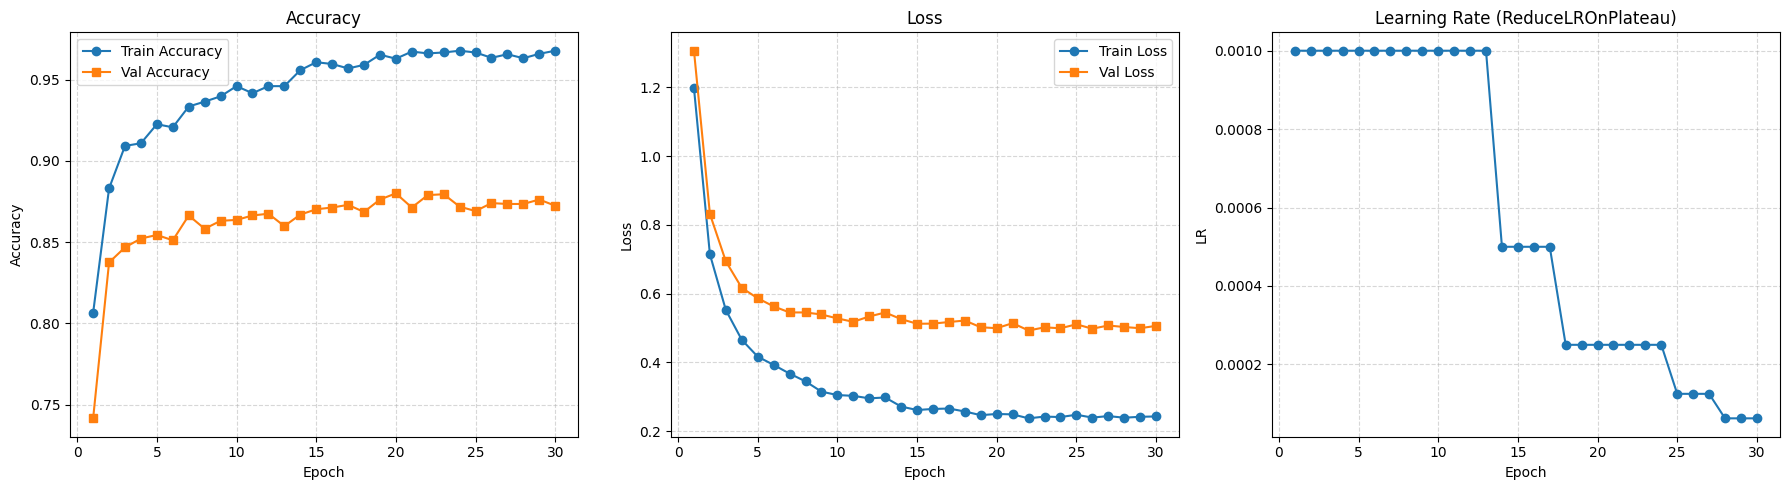

In [ ]:
plot_training_history(
    history_train_acc,
    history_val_acc,
    history_train_loss,
    history_val_loss,
    history_lr)

In [ ]:
trainer.load_best_weights("best_onlyclassifier.pt")
loss_test, acc_test = trainer.eval("test")

In [ ]:
print(f"Results on test set - fine-tuning only the classifier:\nTest loss = {loss_test:.4f} | Test acc = {acc_test:.4f}")

Results on test set - fine-tuning only the classifier:
Test loss = 0.4464 | Test acc = 0.8754


## Results - Frozen Backbone

|  | **ResNet-18 (Frozen Backbone)** |
|---|----------------------------------|
| **Test Loss** | 0.4464 |
| **Test Accuracy (%)** | 87.54 |

Even without fine-tuning the backbone, the model significantly outperforms our custom CNN $69.58\%$.  
 This shows that the pretrained backbone already extracts meaningful and general visual features that transfer well to our dataset. The performance remains strong with minimal computational cost.


In [ ]:
results_transfer = {}
results_transfer['only_classifier'] = {
    "accuracy": acc_test,
    "loss": loss_test
}

In [ ]:
def get_class_names_from_dataset(dataset):
    """
    Builds a mapping from label_id to class_name using dataset.names and dataset.labels.
    """
    id_to_class = {}

    for name, label in zip(dataset.names, dataset.labels):
        class_name = name.rsplit("_", 1)[0]

        if label not in id_to_class:
            id_to_class[label] = class_name

    num_classes = max(dataset.labels) + 1
    class_names = [id_to_class[i] for i in range(num_classes)]

    return class_names

test_mul_acc = trainer.eval_per_class_accuracy("test", "best_onlyclassifier.pt")
class_names = get_class_names_from_dataset(test_dataset2)



Weights loaded successfully.


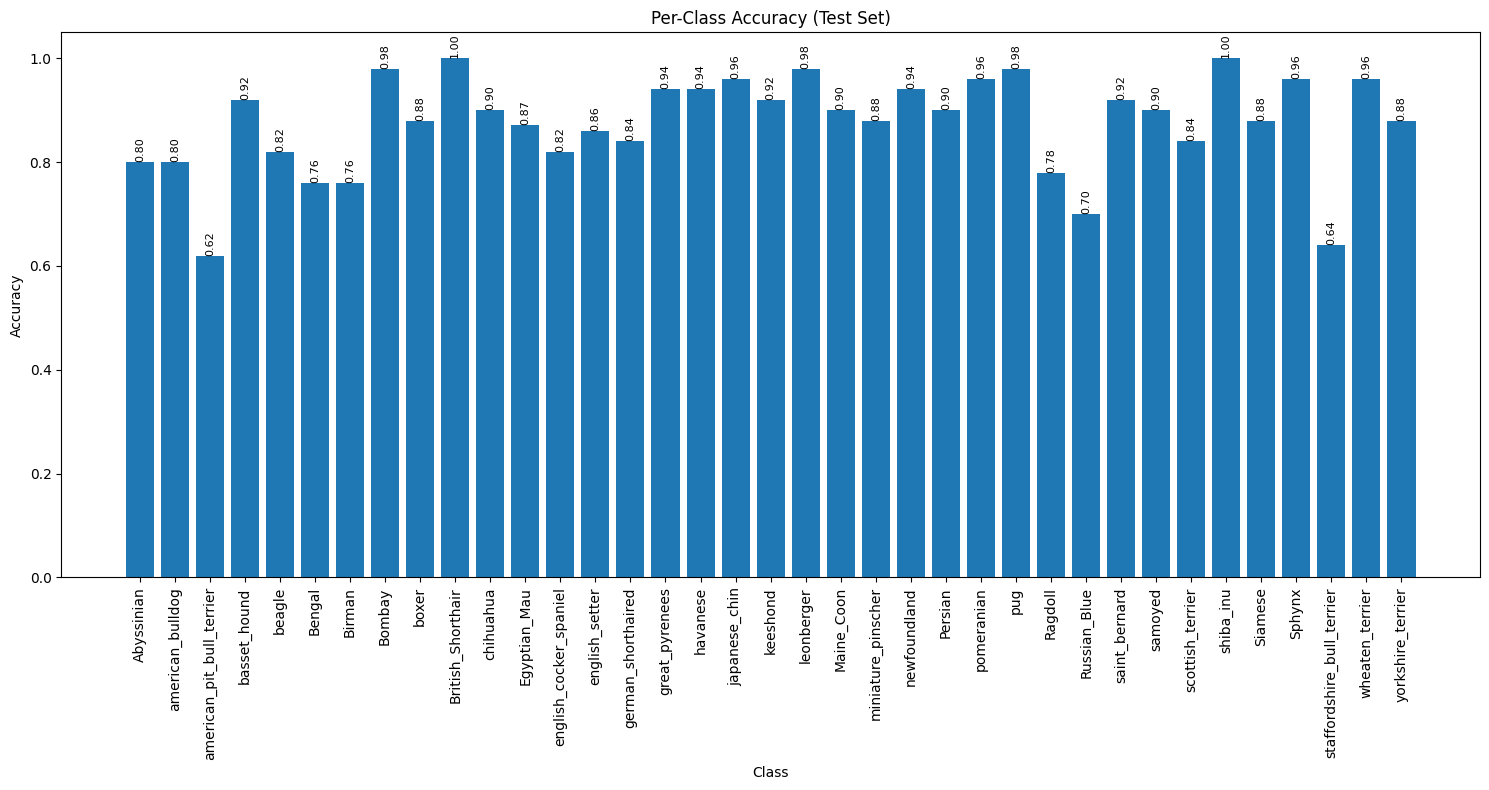

In [ ]:
def plot_multiclass_accuracy(accuracies, class_names):
    plt.figure(figsize=(15, 8))
    bars = plt.bar(class_names, accuracies)

    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy (Test Set)')
    plt.xticks(rotation=90)

    # Add value on top of each bar
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{acc:.2f}',
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=90
        )

    plt.tight_layout()
    plt.show()

plot_multiclass_accuracy(test_mul_acc, class_names)

## **2B Fine-tuning**

For the fine-tuning phase, we experimented with two different configurations:

In the first setting, all layers of the network were unfrozen and the entire model was fine-tuned.

In the second setting, only the last residual block (layer4) and the classifier were unfrozen, while the remaining layers were kept frozen.

The initial learning rate was set to be 100 times smaller than the one used in experiment 2A to ensure more stable updates during fine-tuning. Additionally, the model was trained for half the number of epochs compared to 2A. Finally, the reduction factor of the ReduceLROnPlateau scheduler was adjusted from 0.5 to 0.2 to allow for more conservative learning rate decay.

## **Unfreeze all layers**

 What We Changed
- Reduced learning rate from **1e-3 → 1e-5**
- Reduced minimum LR to **1e-8**
- Used `ReduceLROnPlateau` with factor = 0.2
- Reduced number of epochs to 15
- Used weight decay = 1e-2
- Applied MixUp (α = 0.4)
- Strong data augmentation (RandomResizedCrop, ColorJitter)

 **Justification**

When unfreezing all layers, the model becomes highly sensitive to large gradient updates. Using the original learning rate (1e-3) would distort pretrained ImageNet features too aggressively. Therefore, we reduced the learning rate to **1e-5**, which is standard practice in transfer learning when fine-tuning all layers.

This follows recommendations from:

- Howard & Ruder (2018), *ULMFiT* – smaller learning rates for pretrained layers  
- PyTorch Transfer Learning Tutorial – recommends lowering LR when fine-tuning entire models  

The scheduler with `ReduceLROnPlateau` further refines optimization once validation loss stops improving, allowing fine convergence near minima.

Weight decay (1e-2) and MixUp (α = 0.4) were used to counter overfitting, since fully training the network significantly increases model capacity.




In [ ]:
trainer.lr = 1e-5
trainer._min_lr = 1e-8
trainer._factor_scheduler = 0.2
trainer.num_epochs = 15
trainer.unfreeze_all()
summary(trainer.model, input_size=(3, 224, 224), device=device.type)

Optimizer and scheduler rebuilt with trainable parameters only.
Optimizer and scheduler rebuilt with trainable parameters only.
All model parameters are now trainable.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0

In [ ]:
history_train_loss2, history_train_acc2, history_val_loss2, history_val_acc2, history_lr2 = trainer.train(file_weights="best_finetuning.pt")

Epoch:   7%|▋         | 1/15 [00:45<10:39, 45.68s/it]

Epoch [1/15] | LR: 0.000010 | Train Loss: 0.2156 | Train Acc: 0.9706 | Val Loss: 0.4840 | Val Acc: 0.8795


Epoch:  13%|█▎        | 2/15 [01:30<09:50, 45.45s/it]

Epoch [2/15] | LR: 0.000010 | Train Loss: 0.2115 | Train Acc: 0.9714 | Val Loss: 0.4879 | Val Acc: 0.8811


Epoch:  20%|██        | 3/15 [02:16<09:08, 45.71s/it]

Epoch [3/15] | LR: 0.000010 | Train Loss: 0.1906 | Train Acc: 0.9785 | Val Loss: 0.4795 | Val Acc: 0.8833


Epoch:  27%|██▋       | 4/15 [03:02<08:21, 45.55s/it]

Epoch [4/15] | LR: 0.000010 | Train Loss: 0.1723 | Train Acc: 0.9826 | Val Loss: 0.4685 | Val Acc: 0.8882


Epoch:  33%|███▎      | 5/15 [03:47<07:34, 45.50s/it]

Epoch [5/15] | LR: 0.000010 | Train Loss: 0.1727 | Train Acc: 0.9853 | Val Loss: 0.4729 | Val Acc: 0.8844


Epoch:  40%|████      | 6/15 [04:33<06:49, 45.53s/it]

Epoch [6/15] | LR: 0.000010 | Train Loss: 0.1593 | Train Acc: 0.9877 | Val Loss: 0.4670 | Val Acc: 0.8828


Epoch:  47%|████▋     | 7/15 [05:19<06:05, 45.67s/it]

Epoch [7/15] | LR: 0.000010 | Train Loss: 0.1578 | Train Acc: 0.9888 | Val Loss: 0.4747 | Val Acc: 0.8866


Epoch:  53%|█████▎    | 8/15 [06:06<05:22, 46.04s/it]

Epoch [8/15] | LR: 0.000010 | Train Loss: 0.1518 | Train Acc: 0.9916 | Val Loss: 0.4690 | Val Acc: 0.8860


Epoch:  60%|██████    | 9/15 [06:51<04:35, 45.84s/it]

Epoch [9/15] | LR: 0.000010 | Train Loss: 0.1409 | Train Acc: 0.9902 | Val Loss: 0.4594 | Val Acc: 0.8882


Epoch:  67%|██████▋   | 10/15 [07:37<03:49, 45.81s/it]

Epoch [10/15] | LR: 0.000010 | Train Loss: 0.1422 | Train Acc: 0.9945 | Val Loss: 0.4711 | Val Acc: 0.8871


Epoch:  73%|███████▎  | 11/15 [08:22<03:02, 45.60s/it]

Epoch [11/15] | LR: 0.000010 | Train Loss: 0.1278 | Train Acc: 0.9962 | Val Loss: 0.4636 | Val Acc: 0.8888


Epoch:  80%|████████  | 12/15 [09:07<02:16, 45.46s/it]

Epoch [12/15] | LR: 0.000010 | Train Loss: 0.1220 | Train Acc: 0.9956 | Val Loss: 0.4583 | Val Acc: 0.8882


Epoch:  87%|████████▋ | 13/15 [09:52<01:30, 45.32s/it]

Epoch [13/15] | LR: 0.000010 | Train Loss: 0.1219 | Train Acc: 0.9967 | Val Loss: 0.4668 | Val Acc: 0.8899


Epoch:  93%|█████████▎| 14/15 [10:37<00:45, 45.29s/it]

Epoch [14/15] | LR: 0.000010 | Train Loss: 0.1132 | Train Acc: 0.9967 | Val Loss: 0.4642 | Val Acc: 0.8866


Epoch: 100%|██████████| 15/15 [11:22<00:00, 45.52s/it]

LR reduced from 1.000000e-05 to 2.000000e-06 at epoch 15
Epoch [15/15] | LR: 0.000002 | Train Loss: 0.1144 | Train Acc: 0.9959 | Val Loss: 0.4704 | Val Acc: 0.8877


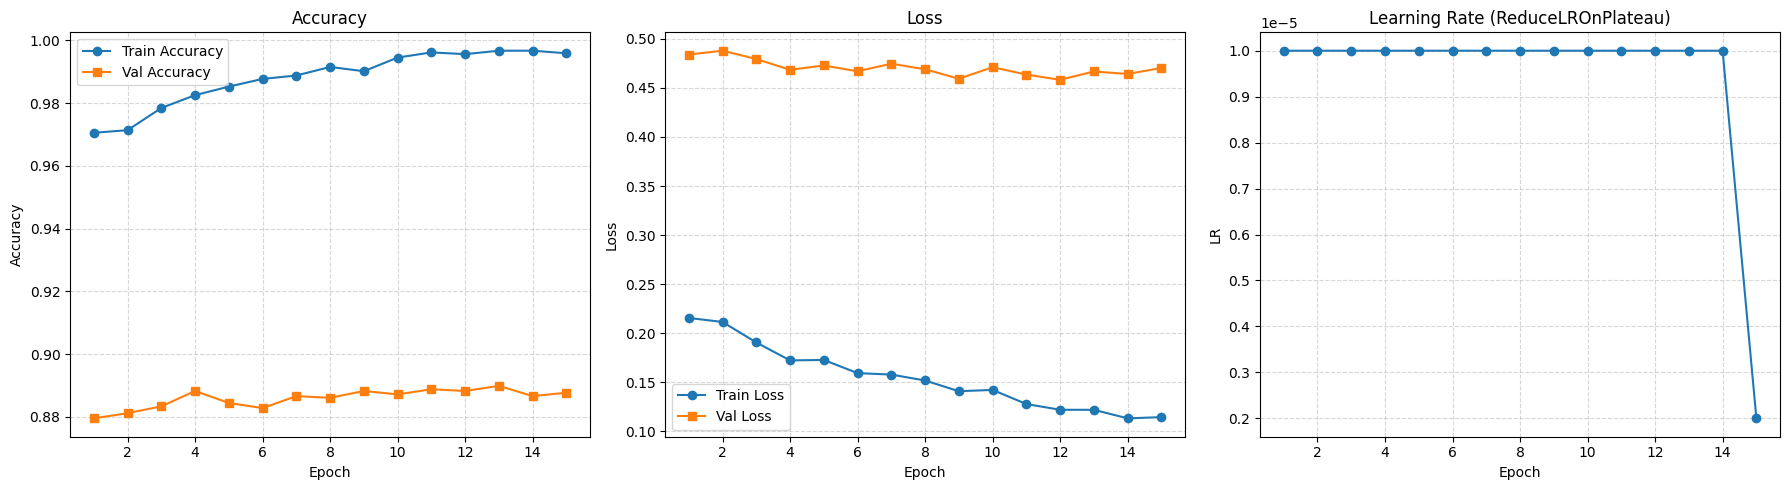

In [ ]:
plot_training_history(
    history_train_acc2,
    history_val_acc2,
    history_train_loss2,
    history_val_loss2,
    history_lr2)

In [ ]:
trainer.load_best_weights('best_finetuning.pt')
loss_test, acc_test = trainer.eval("test")

In [ ]:
results_transfer['all_layers'] = {
    "accuracy": acc_test,
    "loss": loss_test
}

In [ ]:
print(f"Results on test set - fine-tuning on all the layers:\nTest loss = {loss_test:.4f} | Test acc = {acc_test:.4f}")

Results on test set - fine-tuning on all the layers:
Test loss = 0.4079 | Test acc = 0.8949


|  | **ResNet-18 (All layers)** |
|---|----------------------------------|
| **Test Loss** | 0.4079 |
| **Test Accuracy (%)** | 89.49 |

In the fully fine-tuned model, all layers were updated during training. This allows the network to adjust even low-level features to better match the dataset. As a result, this configuration achieves the lowest test loss and the highest test accuracy. However, the improvement over partial fine-tuning is relatively small. Considering the increased training time and computational cost, the practical benefit is limited. This suggests that the pretrained features were already well aligned with our task, and only minor refinements were necessary. None the less we have reached the approx. $90\%$ treshold.

In [ ]:
test_mul_acc2 = trainer.eval_per_class_accuracy("test", "best_finetuning.pt")
class_names = get_class_names_from_dataset(test_dataset2)

Weights loaded successfully.


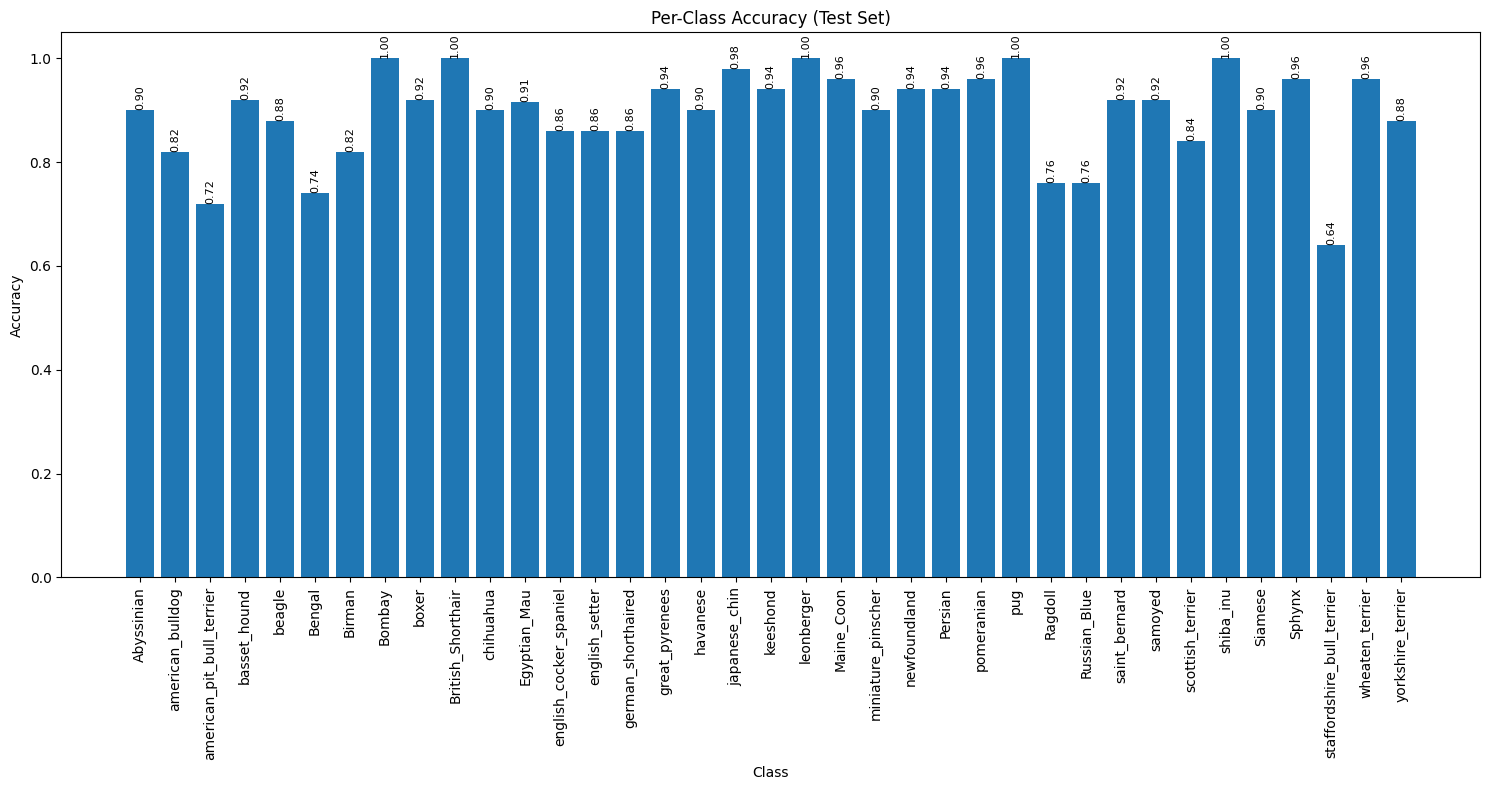

In [ ]:
plot_multiclass_accuracy(test_mul_acc2, class_names)

## **Unfreeze only layer 4 and classifier**

### What We Changed
- Reduced learning rate to **1e-5**
- Used same scheduler configuration
- Trained only Layer 4 and classifier
- Maintained MixUp and augmentation

### Justification

Since only high-level layers were unfrozen, the risk of destroying low-level pretrained features was smaller. However, we still used a reduced learning rate (1e-5) to ensure stable adaptation of semantic features.

According to:

- Yosinski et al. (2014), *How transferable are features in deep neural networks?*  
  → Higher layers are more task-specific and benefit most from fine-tuning.

Keeping earlier layers frozen preserves general edge/texture detectors, while adapting Layer 4 allows specialization to our dataset.

MixUp and augmentation improved generalization, especially visible in reduced validation–training gaps.


The key improvement in both configurations was **lowering the learning rate during fine-tuning**.  
Without this adjustment, pretrained representations would be overwritten too aggressively.


In [ ]:
trainer.lr = 1e-5
trainer._min_lr = 1e-8
trainer._factor_scheduler = 0.2
trainer.num_epochs = 15
trainer.unfreeze_fc_layer4()
summary(trainer.model, input_size=(3, 224, 224), device=device.type)

Optimizer and scheduler rebuilt with trainable parameters only.
Optimizer and scheduler rebuilt with trainable parameters only.
Training only classifier and layer 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
  

In [ ]:
history_train_loss3, history_train_acc3, history_val_loss3, history_val_acc3, history_lr3 = trainer.train(file_weights="best_finetuning2.pt")

Epoch:   7%|▋         | 1/15 [00:45<10:34, 45.31s/it]

Epoch [1/15] | LR: 0.00001000 | Train Loss: 0.2412 | Train Acc: 0.9681 | Val Loss: 0.5086 | Val Acc: 0.8757


Epoch:  13%|█▎        | 2/15 [01:31<09:54, 45.76s/it]

Epoch [2/15] | LR: 0.00001000 | Train Loss: 0.2295 | Train Acc: 0.9706 | Val Loss: 0.4952 | Val Acc: 0.8817


Epoch:  20%|██        | 3/15 [02:16<09:07, 45.59s/it]

Epoch [3/15] | LR: 0.00001000 | Train Loss: 0.2168 | Train Acc: 0.9733 | Val Loss: 0.4982 | Val Acc: 0.8822


Epoch:  27%|██▋       | 4/15 [03:01<08:19, 45.43s/it]

Epoch [4/15] | LR: 0.00001000 | Train Loss: 0.2250 | Train Acc: 0.9763 | Val Loss: 0.5066 | Val Acc: 0.8822


Epoch:  33%|███▎      | 5/15 [03:47<07:35, 45.52s/it]

Epoch [5/15] | LR: 0.00001000 | Train Loss: 0.1956 | Train Acc: 0.9820 | Val Loss: 0.4942 | Val Acc: 0.8811


Epoch:  40%|████      | 6/15 [04:33<06:50, 45.66s/it]

Epoch [6/15] | LR: 0.00001000 | Train Loss: 0.1829 | Train Acc: 0.9809 | Val Loss: 0.4860 | Val Acc: 0.8811


Epoch:  47%|████▋     | 7/15 [05:18<06:04, 45.51s/it]

Epoch [7/15] | LR: 0.00001000 | Train Loss: 0.1914 | Train Acc: 0.9858 | Val Loss: 0.4985 | Val Acc: 0.8828


Epoch:  53%|█████▎    | 8/15 [06:04<05:19, 45.66s/it]

Epoch [8/15] | LR: 0.00001000 | Train Loss: 0.1660 | Train Acc: 0.9880 | Val Loss: 0.4834 | Val Acc: 0.8795


Epoch:  60%|██████    | 9/15 [06:49<04:32, 45.49s/it]

Epoch [9/15] | LR: 0.00001000 | Train Loss: 0.1687 | Train Acc: 0.9872 | Val Loss: 0.4866 | Val Acc: 0.8822


Epoch:  67%|██████▋   | 10/15 [07:35<03:47, 45.54s/it]

Epoch [10/15] | LR: 0.00001000 | Train Loss: 0.1639 | Train Acc: 0.9899 | Val Loss: 0.4942 | Val Acc: 0.8817


Epoch:  73%|███████▎  | 11/15 [08:21<03:02, 45.52s/it]

Epoch [11/15] | LR: 0.00001000 | Train Loss: 0.1561 | Train Acc: 0.9902 | Val Loss: 0.4826 | Val Acc: 0.8822


Epoch:  80%|████████  | 12/15 [09:06<02:16, 45.48s/it]

Epoch [12/15] | LR: 0.00001000 | Train Loss: 0.1632 | Train Acc: 0.9924 | Val Loss: 0.4940 | Val Acc: 0.8828


Epoch:  87%|████████▋ | 13/15 [09:51<01:30, 45.40s/it]

Epoch [13/15] | LR: 0.00001000 | Train Loss: 0.1502 | Train Acc: 0.9918 | Val Loss: 0.4899 | Val Acc: 0.8833


Epoch:  93%|█████████▎| 14/15 [10:36<00:45, 45.32s/it]

LR reduced from 1.000000e-05 to 2.000000e-06 at epoch 14
Epoch [14/15] | LR: 0.00000200 | Train Loss: 0.1595 | Train Acc: 0.9913 | Val Loss: 0.5081 | Val Acc: 0.8828


Epoch: 100%|██████████| 15/15 [11:22<00:00, 45.48s/it]

Epoch [15/15] | LR: 0.00000200 | Train Loss: 0.1553 | Train Acc: 0.9926 | Val Loss: 0.5028 | Val Acc: 0.8822


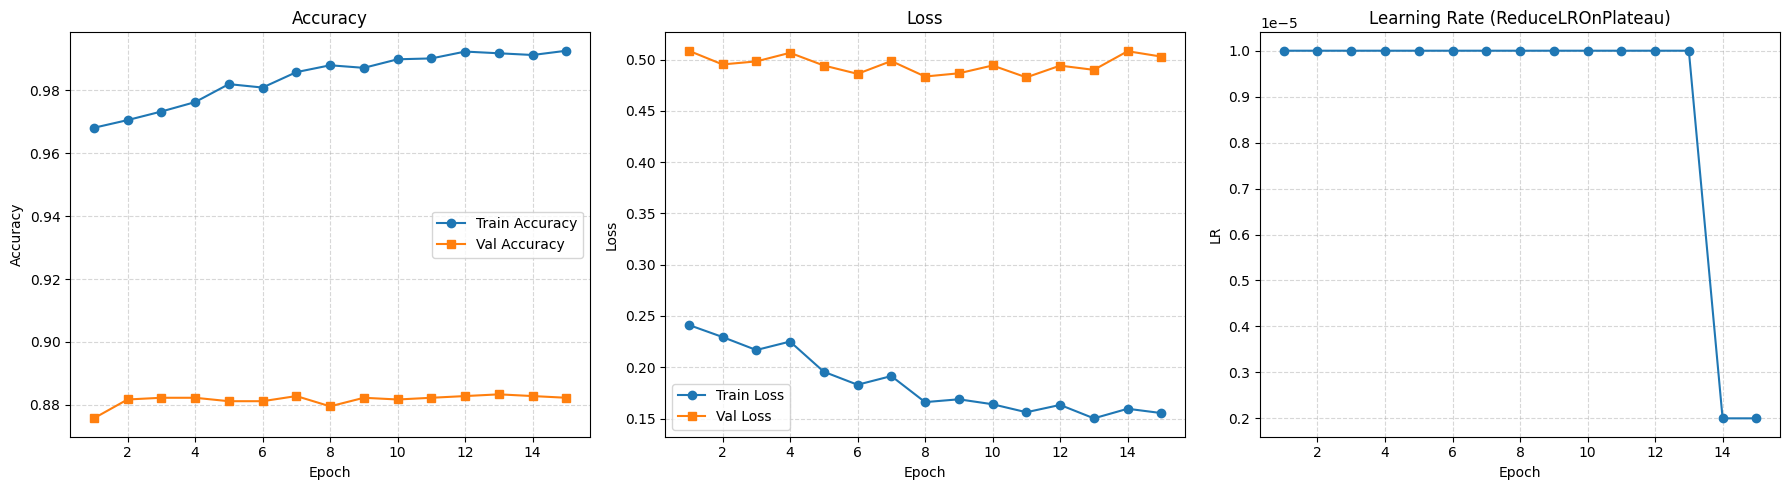

In [ ]:
plot_training_history(
    history_train_acc3,
    history_val_acc3,
    history_train_loss3,
    history_val_loss3,
    history_lr3)

In [ ]:
trainer.load_best_weights('best_finetuning2.pt')
loss_test, acc_test = trainer.eval("test")

In [ ]:
results_transfer['layer4_classifier'] = {
    "accuracy": acc_test,
    "loss": loss_test
}

In [ ]:
print(f"Results on test set - fine-tuning on layer 4 and classifier:\nTest loss = {loss_test:.4f} | Test acc = {acc_test:.4f}")

Results on test set - fine-tuning on layer 4 and classifier:
Test loss = 0.4332 | Test acc = 0.8884


|  | **ResNet-18 (Layer 4 and classifier)** |
|---|----------------------------------|
| **Test Loss** | 0.4332 |
| **Test Accuracy (%)** | 88.84 |

When fine-tuning Layer 4 together with the classifier, the model gains additional flexibility to adjust high-level semantic features to our dataset. This leads to a noticeable improvement in both test accuracy and test loss compared to the fully frozen setup. The earlier layers still provide stable and general feature extraction, while the last block adapts to more task-specific patterns. This configuration represents a practical balance between performance improvement and computational efficiency.

Weights loaded successfully.


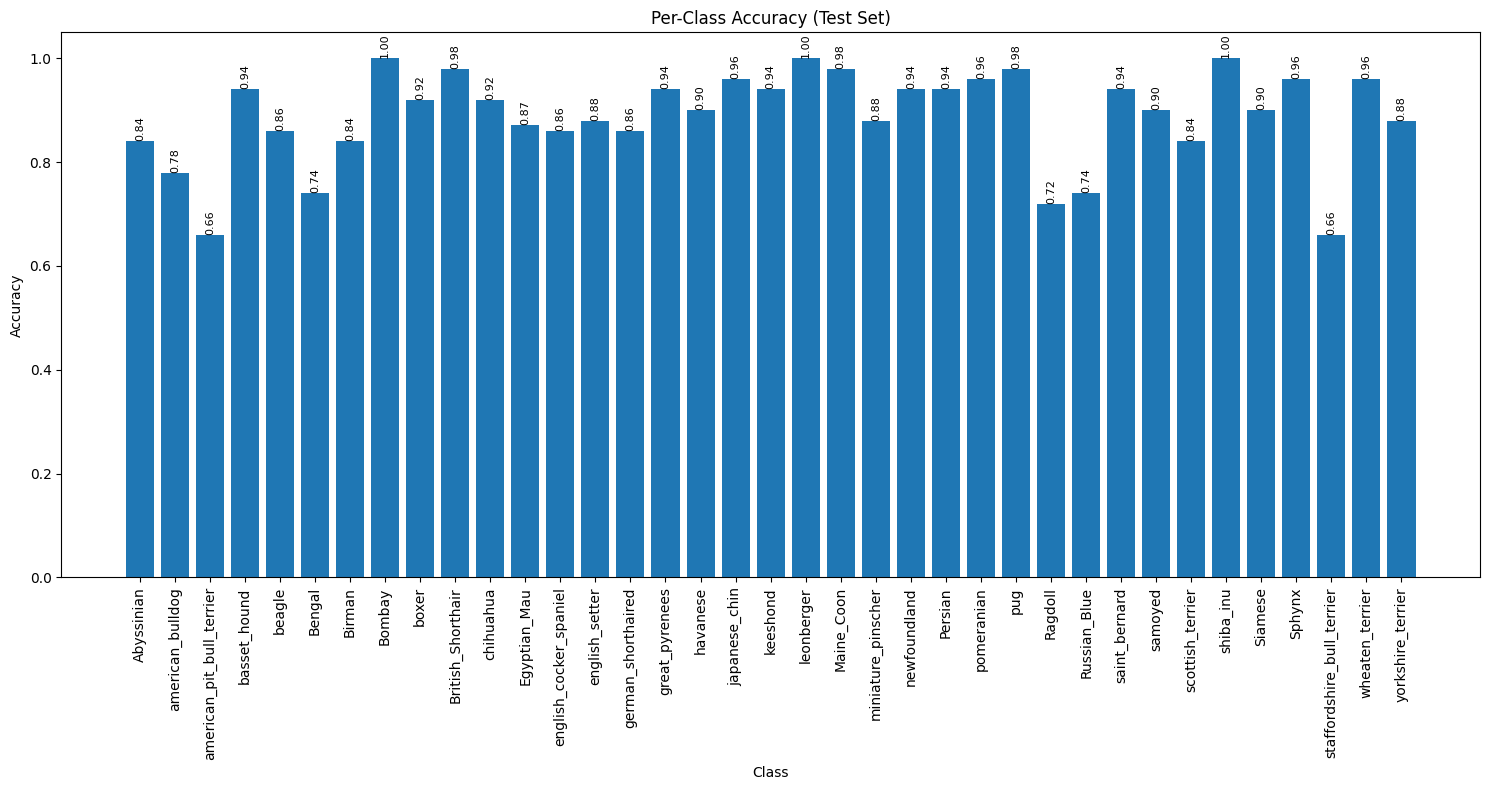

In [ ]:
test_mul_acc3 = trainer.eval_per_class_accuracy("test", "best_finetuning2.pt")
class_names = get_class_names_from_dataset(test_dataset2)
plot_multiclass_accuracy(test_mul_acc3, class_names)

# Conclusion – Part 2

In this study, we evaluated three transfer learning strategies using ResNet-18:

1. Frozen backbone (train classifier only)  
2. Fine-tuning Layer 4 + classifier  
3. Full fine-tuning of all layers  

The final test accuracies were:

- Frozen backbone: **$87.54\%$**
- Layer 4 + classifier: **$88.84\%$**
- Full fine-tuning: **$89.49\%$**

The total improvement from the simplest to the most complex configuration is only **$1.95\%$**, which is relatively small considering the additional computational cost required for full fine-tuning.

These results demonstrate that the pretrained ResNet-18 backbone already provides strong and transferable visual representations. Most of the performance comes from features learned during large-scale pretraining. Fine-tuning higher layers improves dataset-specific adaptation, while fully training all layers yields the best performance but with marginal gains relative to the increased computational cost.

From a practical standpoint:

- Freezing the backbone is computationally efficient while maintaining strong performance.
- Fine-tuning only Layer 4 offers an excellent balance between efficiency and accuracy.
- Full fine-tuning achieves the highest accuracy but with diminishing returns.

Overall, transfer learning proves highly effective for our dataset size, and increasing model complexity yields limited additional benefit.


In [ ]:
df_transfer = pd.DataFrame.from_dict(results_transfer, orient="index")
print('Results from fine-tuned models on test set')
df_transfer


Results from fine-tuned models on test set


accuracy    loss
only_classifier      0.8754  0.4464
all_layers           0.8949  0.4079
layer4_classifier    0.8884  0.4332

**End of Experiment.**